In [1]:
import shap
import warnings
import numpy as np
import pandas as pd
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', None)
import xgboost as xgb
import seaborn as sns
from PIL import Image
import lightgbm as lgb
import scikitplot as skplt
import matplotlib.pyplot as plt
warnings.filterwarnings("ignore")
from matplotlib.gridspec import GridSpec
from sklearn.tree import DecisionTreeClassifier
from scipy.stats import uniform, truncnorm, randint
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score, roc_curve, roc_auc_score
from sklearn.model_selection import train_test_split, KFold, GridSearchCV, RandomizedSearchCV, cross_val_score

Pagina kaggle: https://www.kaggle.com/datasets/shubh0799/churn-modelling

In [2]:
pathDatos = './Datos/'
pathEda = './EDA/EDA_churn_model/'
target = 'exited'

In [3]:
df = pd.read_csv(f'{pathDatos}Churn_Modelling.csv', sep=',')
df.columns = df.columns.str.lower()
print(f'shape: {df.shape}')
df.head()

shape: (10000, 14)


,rownumber,customerid,surname,creditscore,geography,gender,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
0,1,15634602,Hargrave,619,France,Female,42,2,0.00,1,1,1,101348.88,1
1,2,15647311,Hill,608,Spain,Female,41,1,83807.86,1,0,1,112542.58,0
2,3,15619304,Onio,502,France,Female,42,8,159660.80,3,1,0,113931.57,1
3,4,15701354,Boni,699,France,Female,39,1,0.00,2,0,0,93826.63,0
4,5,15737888,Mitchell,850,Spain,Female,43,2,125510.82,1,1,1,79084.10,0


#### Comprobación de valores unicos para las variables categoricas y numericas

In [4]:
df[df.columns[df.dtypes == 'object']].nunique()

surname      2932
geography       3
gender          2
dtype: int64

In [5]:
df[df.columns[df.dtypes != 'object']].nunique()

rownumber          10000
customerid         10000
creditscore          460
age                   70
tenure                11
balance             6382
numofproducts          4
hascrcard              2
isactivemember         2
estimatedsalary     9999
exited                 2
dtype: int64

In [6]:
# Eliminamos las variables que no vamos aportan nada al modelo 
varsRemove = ['surname', 'rownumber', 'customerid']
df.drop(varsRemove, axis=1, inplace=True)
df.dtypes.value_counts().to_dict()

{dtype('int64'): 7, dtype('float64'): 2, dtype('O'): 2}

In [7]:
df.describe()

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited
count,10000.000000,10000.000000,10000.000000,10000.000000,10000.000000,10000.00000,10000.000000,10000.000000,10000.000000
mean,650.528800,38.921800,5.012800,76485.889288,1.530200,0.70550,0.515100,100090.239881,0.203700
std,96.653299,10.487806,2.892174,62397.405202,0.581654,0.45584,0.499797,57510.492818,0.402769
min,350.000000,18.000000,0.000000,0.000000,1.000000,0.00000,0.000000,11.580000,0.000000
25%,584.000000,32.000000,3.000000,0.000000,1.000000,0.00000,0.000000,51002.110000,0.000000
50%,652.000000,37.000000,5.000000,97198.540000,1.000000,1.00000,1.000000,100193.915000,0.000000
75%,718.000000,44.000000,7.000000,127644.240000,2.000000,1.00000,1.000000,149388.247500,0.000000
max,850.000000,92.000000,10.000000,250898.090000,4.000000,1.00000,1.000000,199992.480000,1.000000


&nbsp;
## EDA
##### Utilizando el codigo desarrollado para hacer un analisis exploratorio de los datos obtenemos lo siguiente.
---

In [8]:
def plots_eda(pathEda, var, type_numerical=True, size=(22, 11)):
    
    def __read_img(pathImg, var, type_numerical=True):
    
        if type_numerical == True:
            img_box = Image.open(f'{pathImg}{var}_boxplot_por_target.png')
            img_hist_box = Image.open(f'{pathImg}{var}_hist_boxplot.png')
            img_tram = Image.open(f'{pathImg}{var}_tramificada.png')
            return img_box, img_hist_box, img_tram
        else:
            img_bar = Image.open(f'{pathImg}{var}_barplot.png')
            img_hist = Image.open(f'{pathImg}{var}_hist_por_target.png')
            return img_bar, img_hist
        
    if type_numerical == True:
        fig, (ax1, ax2, ax3) = plt.subplots(1, 3, figsize=size)
        ax1.imshow(np.asarray(__read_img(pathEda, var)[0]), aspect='auto')
        ax2.imshow(np.asarray(__read_img(pathEda, var)[1]), aspect='auto')
        ax3.imshow(np.asarray(__read_img(pathEda, var)[2]), aspect='auto')
        ax1.axis('off')
        ax2.axis('off')
        ax3.axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)
    else:
        fig, (ax1, ax2) = plt.subplots(1, 2, figsize=size)
        ax1.imshow(np.asarray(__read_img(pathEda, var, False)[0]), aspect='auto')
        ax2.imshow(np.asarray(__read_img(pathEda, var, False)[1]), aspect='auto')
        ax1.axis('off')
        ax2.axis('off')
        plt.subplots_adjust(wspace=0, hspace=0)

        
def var_tramitificada_vs_target(df, var, target, n_bins=5, figsize=(14, 8)):

    def __get_cut(df_, var, target, n_bins):

        df_c = df_.copy()
        df_c[f'{var}_cut'] = pd.cut(df_c[var], bins=n_bins, include_lowest=True)
        df_c[f'{var}_cut'] = df_c[f'{var}_cut'].astype(str)    

        df_pr = df_c.groupby(f'{var}_cut').agg({target:['mean', 'count']})
        df_pr.columns = df_pr.columns.droplevel()
        df_pr = df_pr.reset_index()

        return df_pr

    df_plot = __get_cut(df, var, target, n_bins)
    fig, ax1 = plt.subplots(figsize=figsize)
    ax1.bar(df_plot[f'{var}_cut'], df_plot['count'], color='deepskyblue')
    ax2 = ax1.twinx()
    ax2.plot(df_plot[f'{var}_cut'], df_plot['mean'], marker='o', linestyle=':', color='black')
    plt.title(f'Volumen & target rate \n para {var}; target = {target}')
    ax1.set_xlabel(f'{var} buckets')
    ax1.set_ylabel('Volumen (counts)')
    ax2.set_ylabel('Target ratio')
    plt.setp(ax1.get_xticklabels(), rotation=30, horizontalalignment='right')


#### creditscore

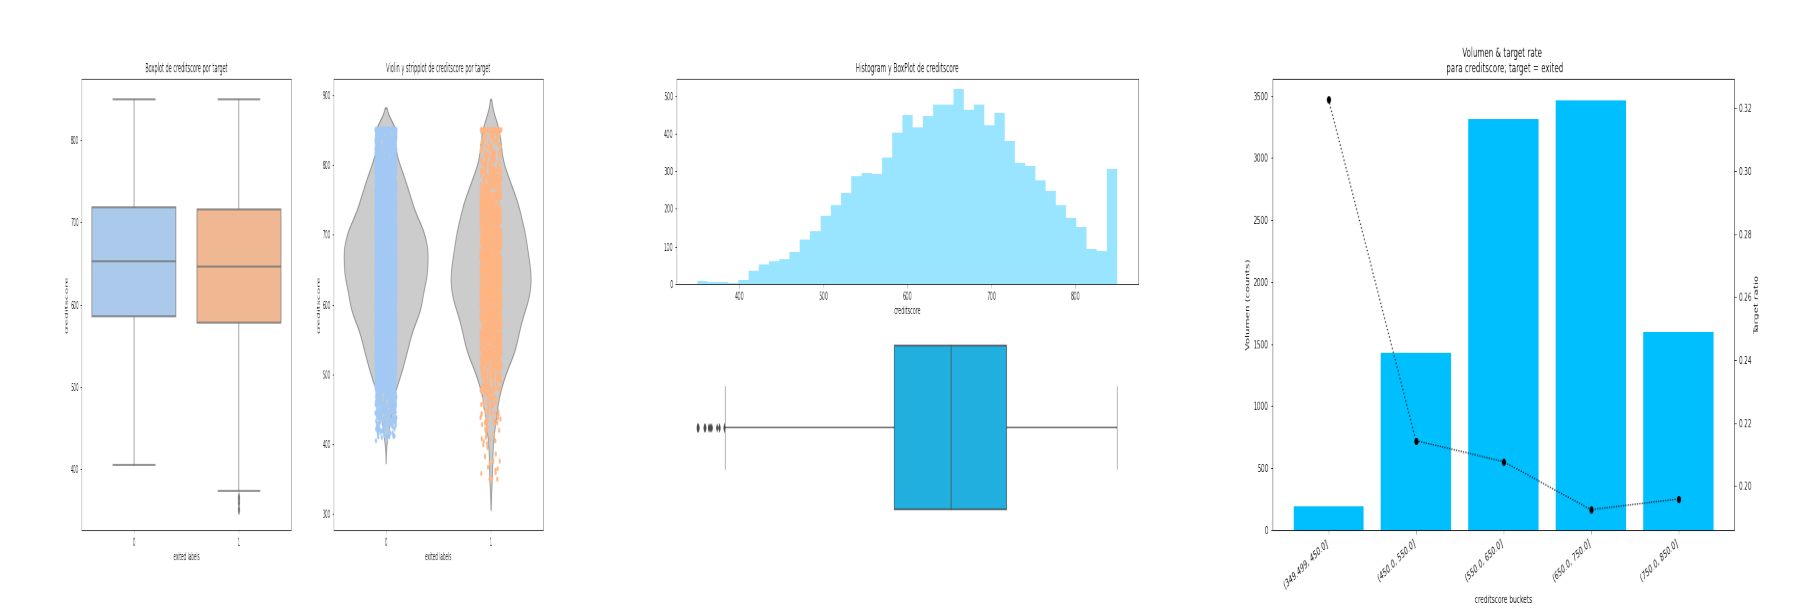

In [9]:
plots_eda(pathEda, 'creditscore', size=(32, 11))

En esta variable se observa como aquellos clientes con un creditscore bajo tienen un mayor ratio de 1´s en la target (mayor proclives a marcarse).

#### geography

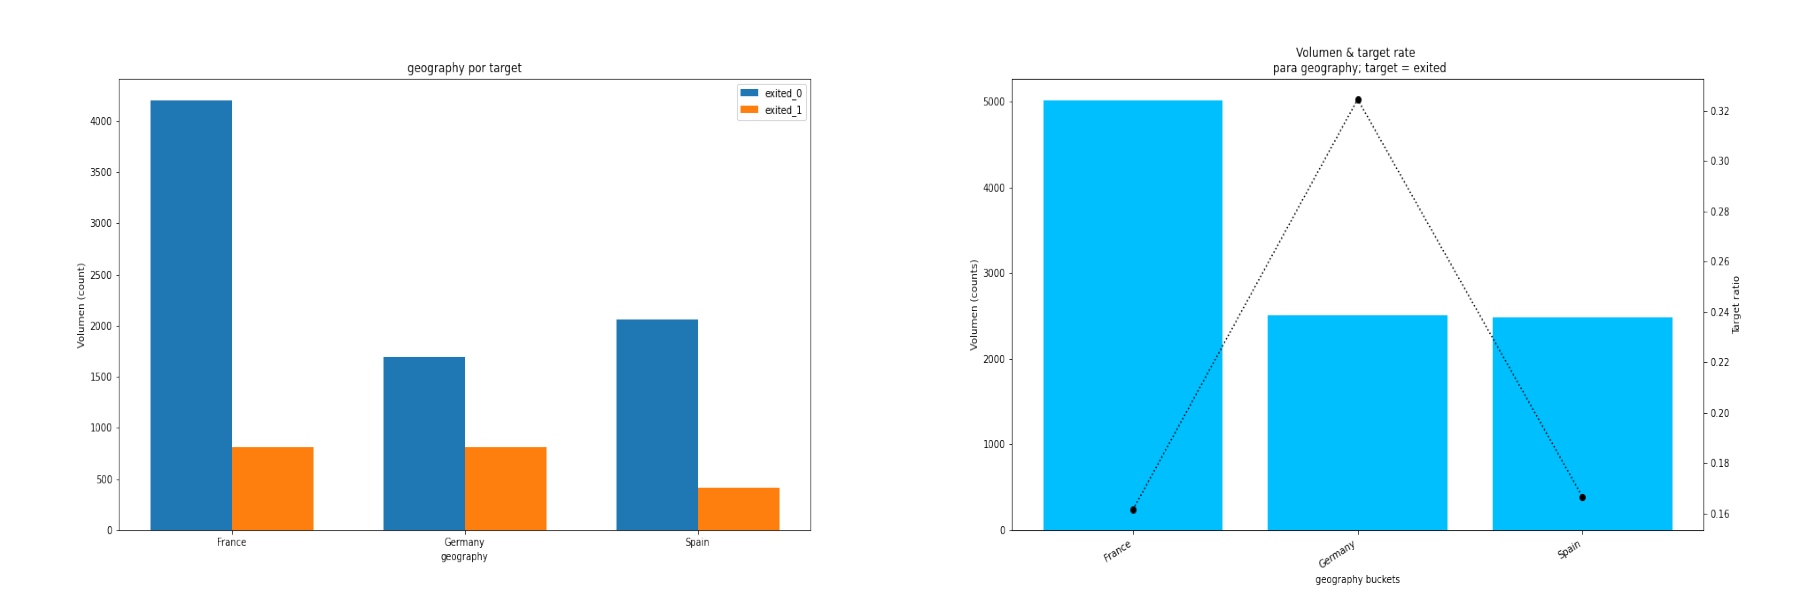

In [10]:
plots_eda(pathEda, 'geography', False, (32, 11))

Dentro de esta variable observamos que aquellos registros con un valor de 'Germany' son mas proclives a marcharse, en las otras dos opciones ('France' y 'Spain' el ratio de 1´s es similar).

#### gender

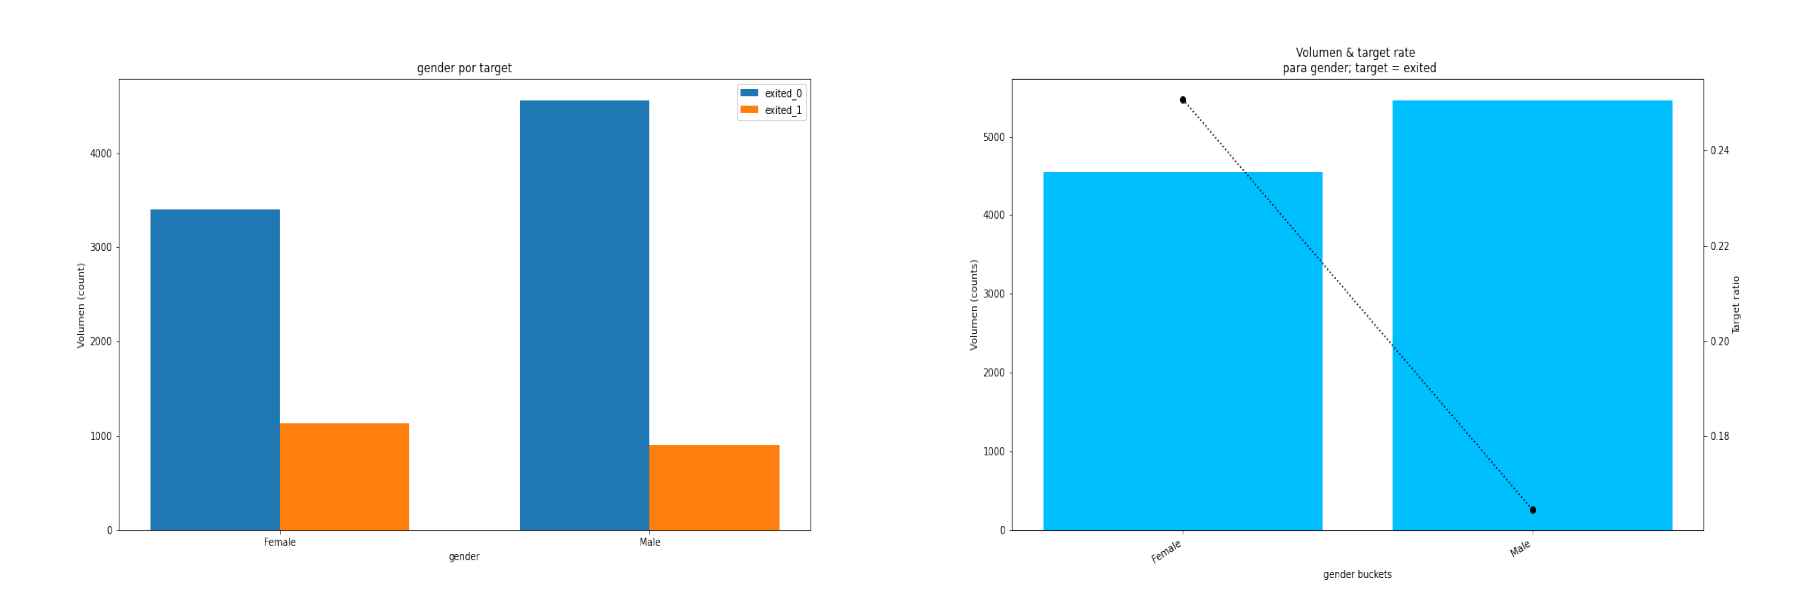

In [11]:
plots_eda(pathEda, 'gender', False, (32, 11))

Nos encontramos con mas registros marcados como 'Male' aunque los marcados como 'Female' tienen un ratio de 1´s superior. 

#### age

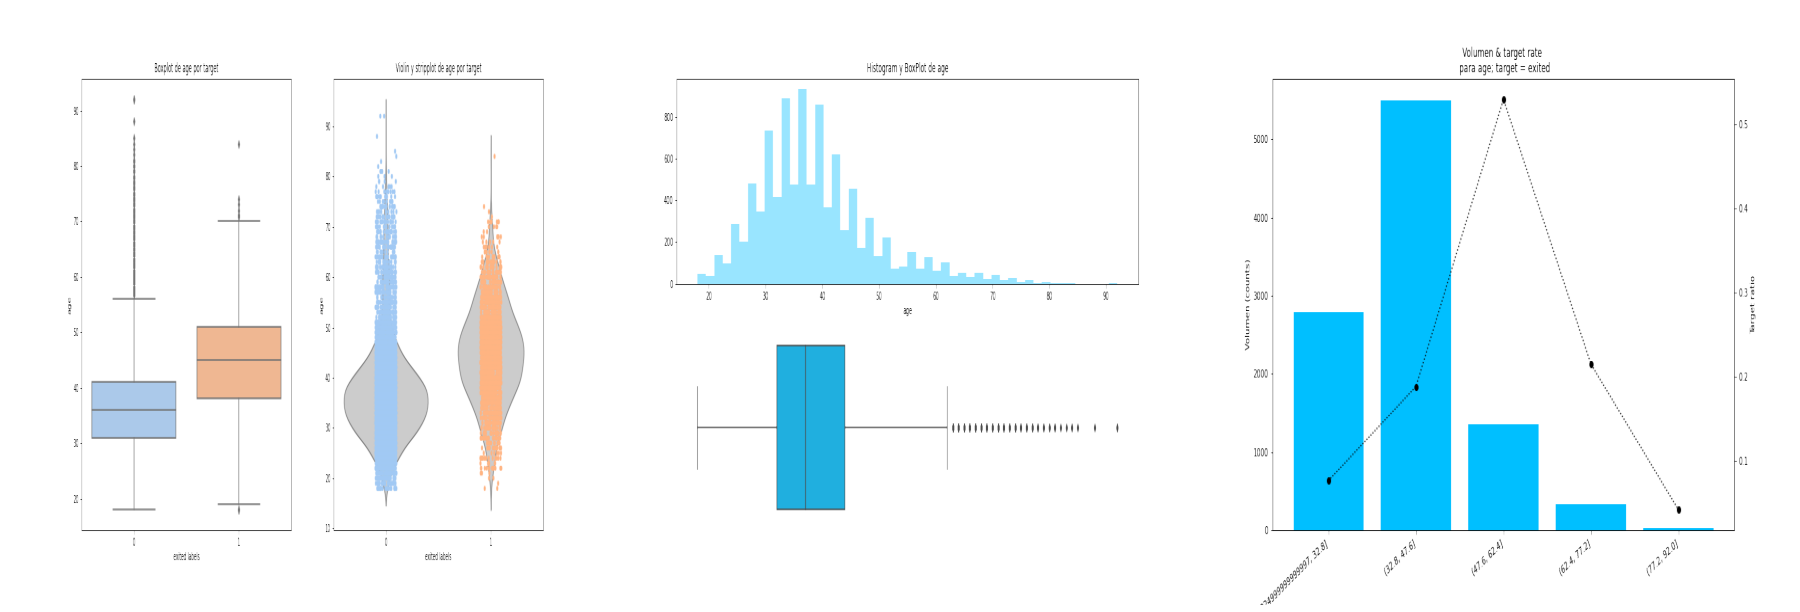

In [12]:
plots_eda(pathEda, 'age', size=(32, 11))

Variable con una serie de outliers, se observa como el ratio de 1´s es muy superior en el rango de edades entre 47 y 62 años

#### tenure

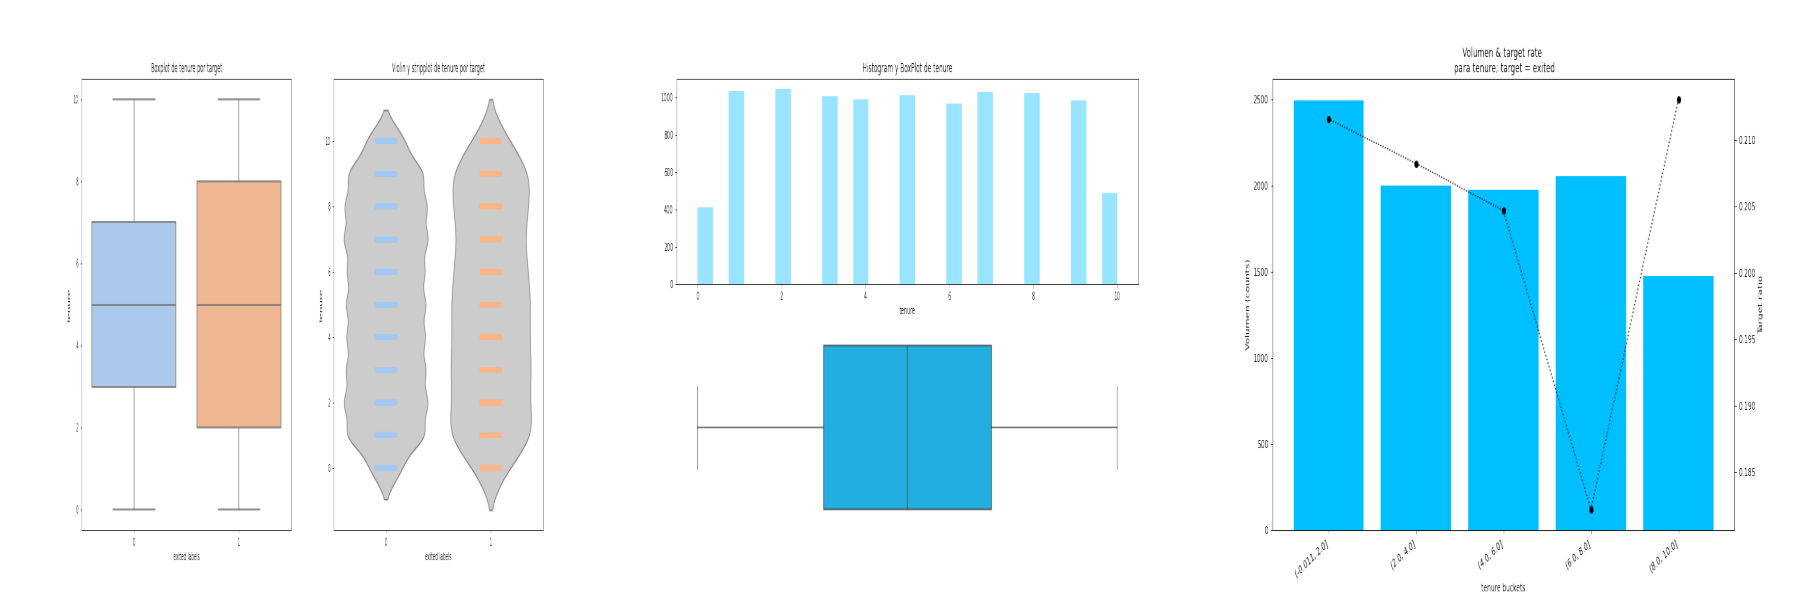

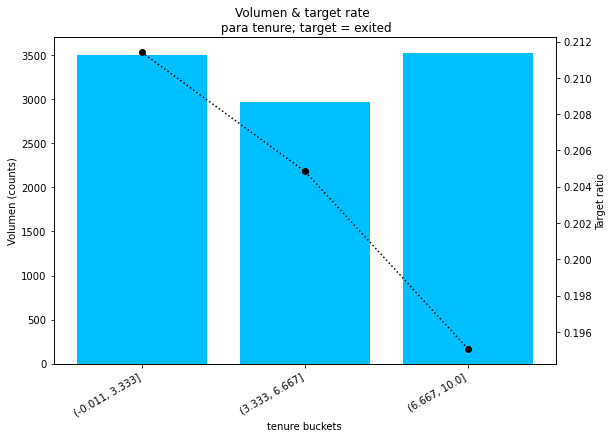

In [13]:
plots_eda(pathEda, 'tenure', size=(32, 11))
var_tramitificada_vs_target(df, 'tenure', target, 3, (9, 6))

Hemos realizado una nueva grafica de la variable tramificada ya que la tramificación en 5 bins no se veia algo claro, al realizar esta tramificacion en 3 bins observamos como el ratio de 1´s es ligeramente superior en aquellos clientes con menor antiguedad, sin embargo esta diferencia no es muy grande.

#### balance

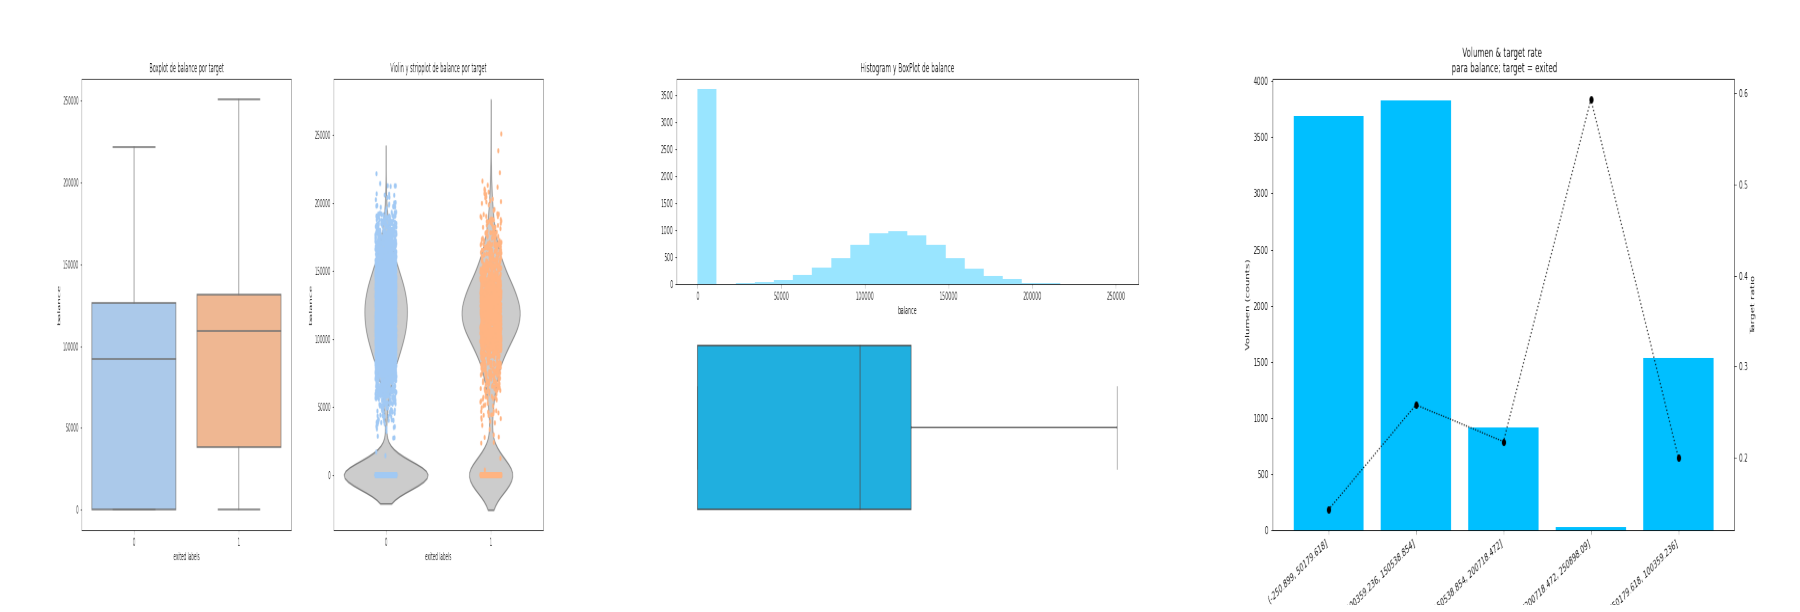

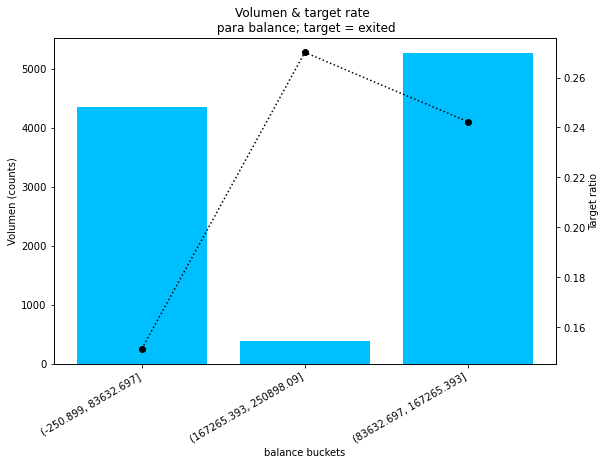

In [14]:
plots_eda(pathEda, 'balance', size=(32, 11))
var_tramitificada_vs_target(df, 'balance', target, 3, (9, 6))

Hemos realizado una nueva grafica de la variable tramificada ya que la tramificación en 5 bins no se veia algo claro, al realizar esta tramificacion en 3 bins observamos como el ratio de 1´s es superior a medida que la variable toma valores mas altos

#### numofproducts

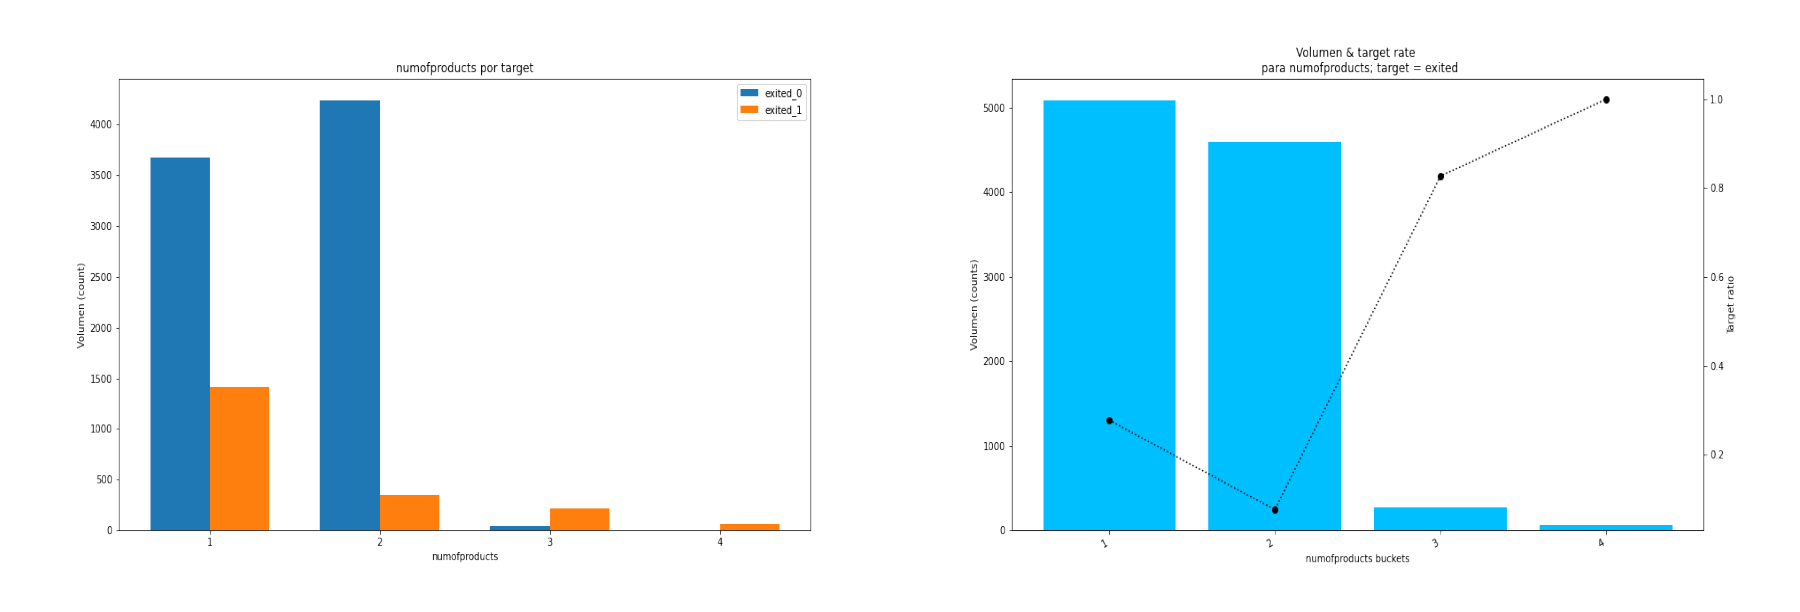

In [15]:
plots_eda(pathEda, 'numofproducts', False, (32, 11))

Se observa como aquellos clientes que tienen mayor cantidad de productos contratados son mas proclives a abandonar la compañia. Tambien observamos como una amplia mayoria de los clientes dispone de 2 o menos productos contratados. Ademas, se observa un ratio de 1´s relativamente alto en aquellos clientes que solo tienen contratado un producto.

#### hascrcard

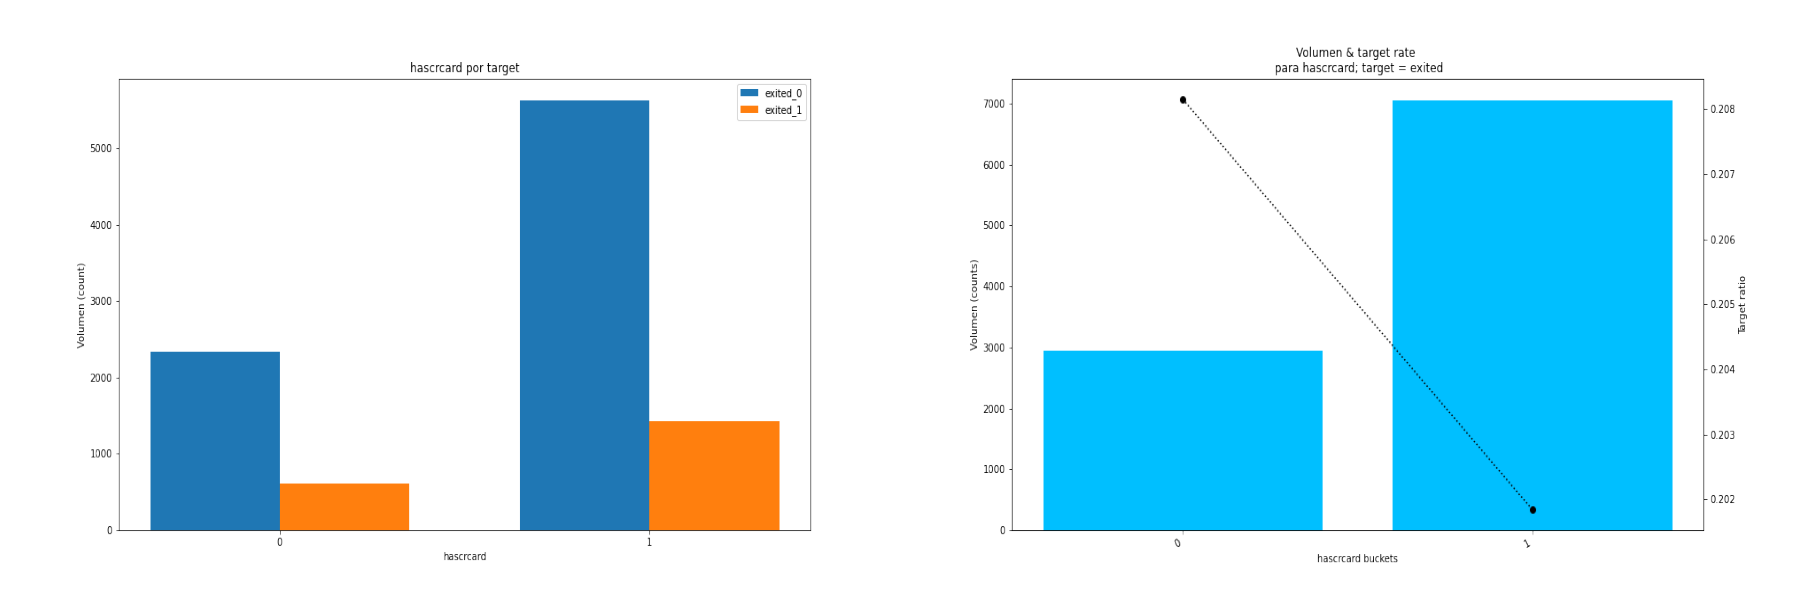

In [16]:
plots_eda(pathEda, 'hascrcard', False, (32, 11))

La mayoria de los registros poseen el valor '1', es decir, clientes que si poseen tarjeta de credito, el ratio de 1´s es muy similar en ambos tipos de clientes (con o sin tarjeta de credito) aunque es ligeramente superior en aquellos clientes que no tienen tarjeta de credito.

#### isactivemember

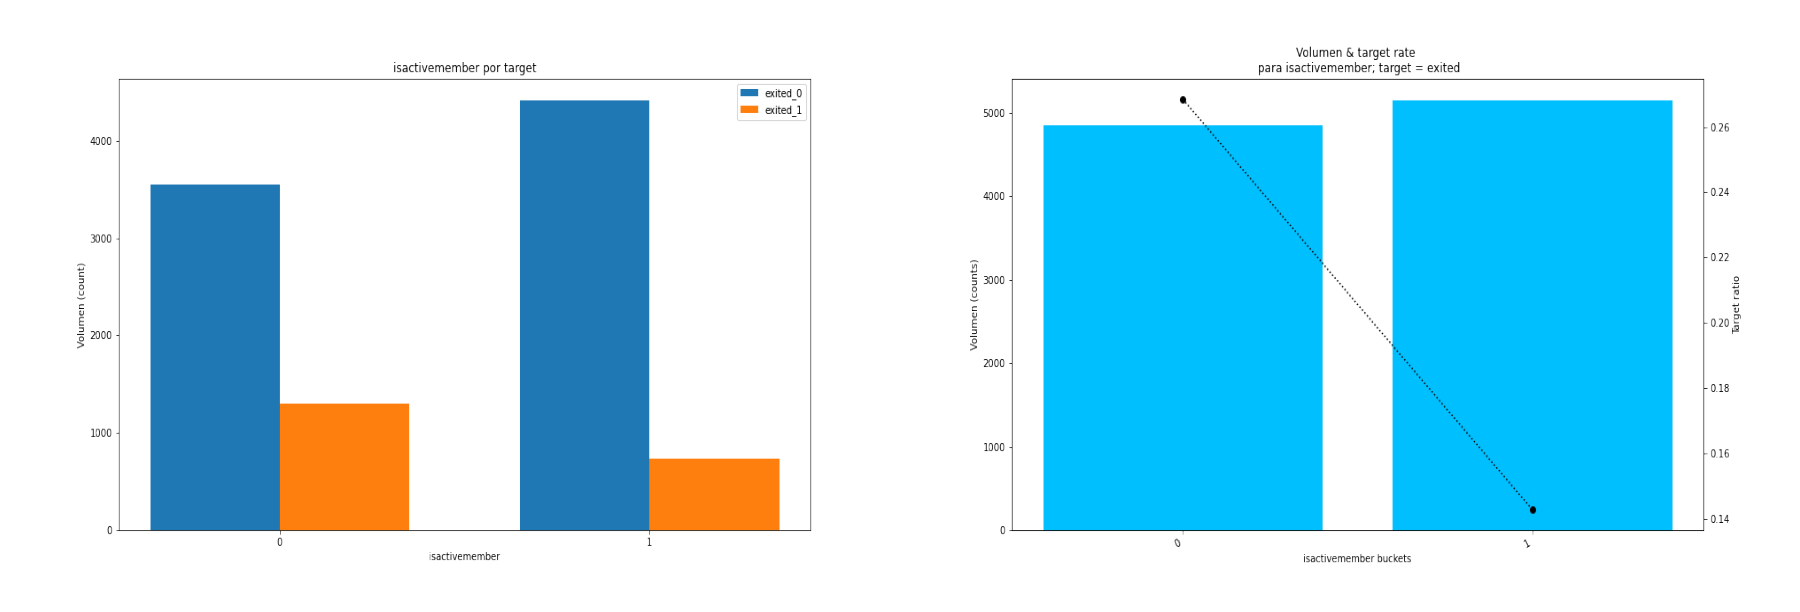

In [17]:
plots_eda(pathEda, 'isactivemember', False, (32, 11))

La proporcion de clientes es muy similar en ambos casos, sin embargo se observa como aquellos clientes que no son miembros muy activos '0' poseen un ratio de 1´s mucho mas elevado, es decir, son mas proclives a abandonar la compañia.

#### estimatedsalary

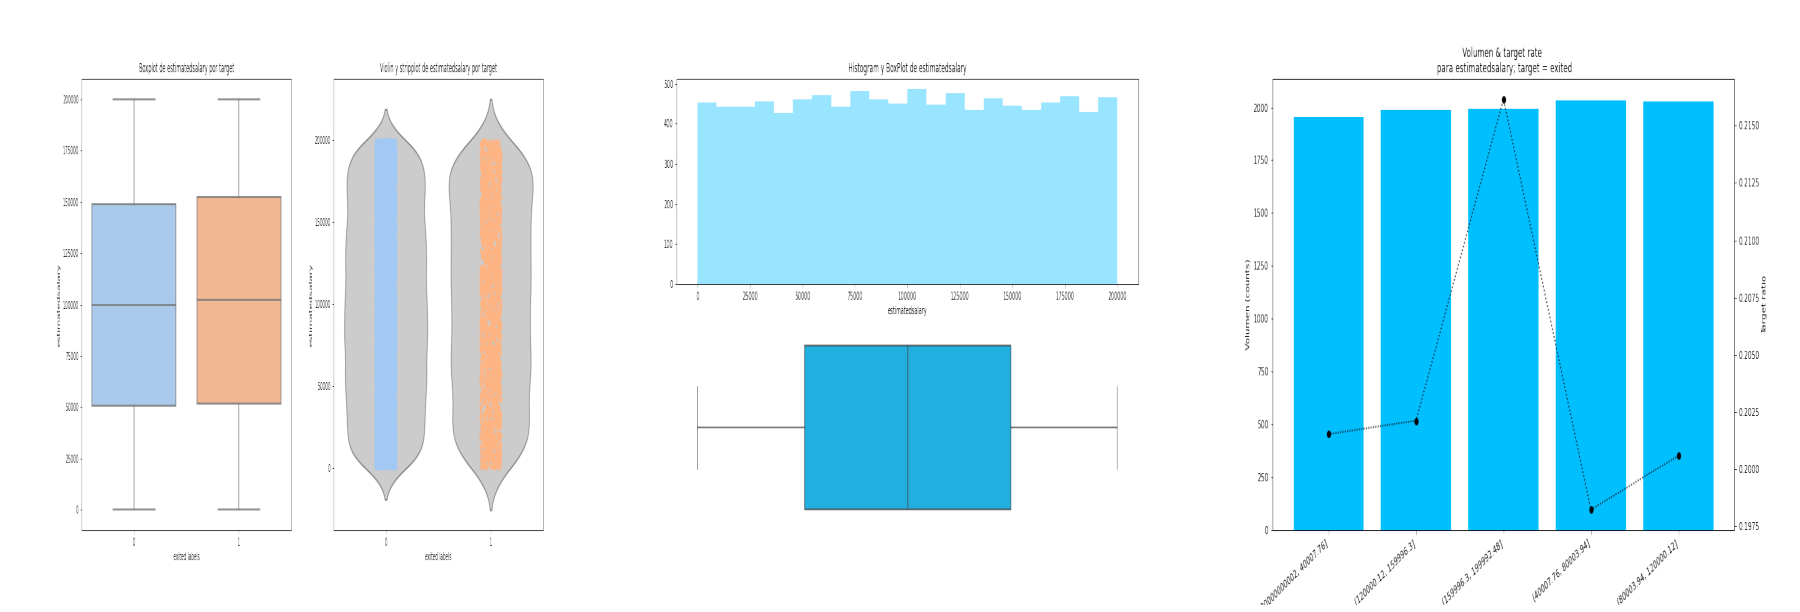

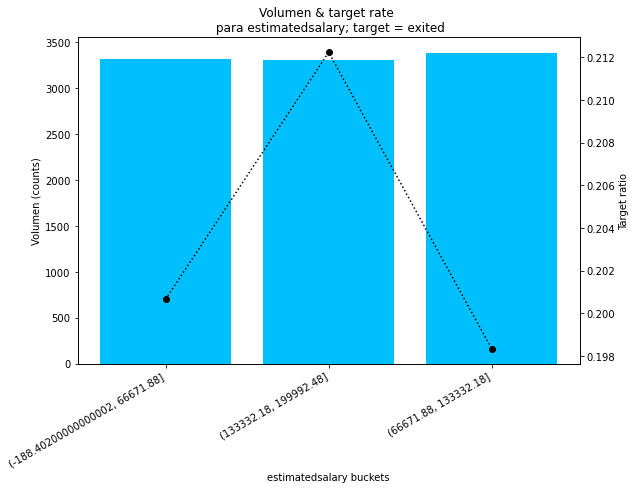

In [18]:
plots_eda(pathEda, 'estimatedsalary', size=(32, 11))
var_tramitificada_vs_target(df, 'estimatedsalary', target, 3, (9, 6))

Hemos realizado una nueva grafica de la variable tramificada ya que la tramificación en 5 bins no se veia algo claro, al realizar esta tramificacion en 3 bins observamos como aquellos clientes con un salario estimado mas alto son mas proclives a abandonar la compañia.

#### exited

<AxesSubplot:xlabel='exited', ylabel='count'>

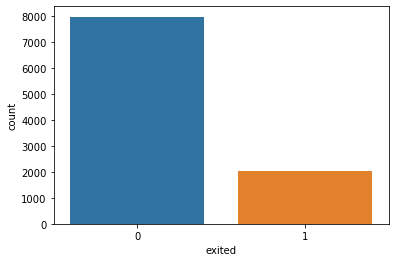

In [19]:
sns.countplot(x=df[target])

El ratio de 1´s es inferior, tenemos una proporcion 20-80.

&nbsp;
## Feature Engineering
---

#### Imputacion de valores perdidos

In [20]:
df.isna().sum()

creditscore        0
geography          0
gender             0
age                0
tenure             0
balance            0
numofproducts      0
hascrcard          0
isactivemember     0
estimatedsalary    0
exited             0
dtype: int64

In [21]:
print(f'Numbero de valores perdidos en el dataset: {df.isna().sum().sum()}')

Numbero de valores perdidos en el dataset: 0


En el dataset no nos encontramos con ningun valor perdido por lo que no habra que realizar ninguna imputacion

#### Generacion de dummies

Generamos dummies para aquellas variables categoricas que lo requieran

In [22]:
# Generamos una lista con las variables categoricas de las cuales debemos de generar dummies.
varsCategorical = df.columns[df.dtypes == 'object'].tolist()
print(varsCategorical)

['geography', 'gender']


In [23]:
for var in varsCategorical:
    df = pd.get_dummies(df, columns=[var])
df.head(2)

,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,exited,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male
0,619,42,2,0.00,1,1,1,101348.88,1,1,0,0,1,0
1,608,41,1,83807.86,1,0,1,112542.58,0,0,0,1,1,0


&nbsp;
## Desarrollo del modelo
---

Vamos a realizar un primer estudio con diferentes modelos y posteriormente se hara un tuneado de hiperparametros de algunos de ellos buscando unos resultados mas optimos

In [24]:
X = df.drop([target], axis=1).copy()
y = df[target].copy()
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=1234)
print(f'shape X_train: {X_train.shape} \nshape X_test: {X_test.shape}')
print(f'shape y_train: {y_train.shape} \nshape y_test: {y_test.shape}')

shape X_train: (8000, 13) 
shape X_test: (2000, 13)
shape y_train: (8000,) 
shape y_test: (2000,)


In [25]:
classifiers = {'XGBClassifier': xgb.XGBClassifier(), 
               'LGBMClassifier': lgb.LGBMClassifier(),
               'LogisticRegression': LogisticRegression(),
               'DecisionTreeClassifier': DecisionTreeClassifier(), 
               'RandomForestClassifier': RandomForestClassifier(),
               'GradientBoostingClassifier': GradientBoostingClassifier()}

results = {}
for i in classifiers:
    model = classifiers[i]
    model.fit(X_train, y_train)
    list_roc = {}
    list_roc['roc_auc_train'] = roc_auc_score(y_train, model.predict_proba(X_train)[::, 1])
    list_roc['roc_auc_test'] = roc_auc_score(y_test, model.predict_proba(X_test)[::, 1])    
    results[i] = list_roc

df_roc_auc_comparative = pd.DataFrame.from_dict(results, orient='index').reset_index()
df_roc_auc_comparative.rename(columns={'index':'modelo', 0:'roc_auc'}, inplace=True)
df_roc_auc_comparative

[15:55:38] WARNING: C:/Users/Administrator/workspace/xgboost-win64_release_1.3.0/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


,modelo,roc_auc_train,roc_auc_test
0,XGBClassifier,0.989816,0.842912
1,LGBMClassifier,0.966943,0.849739
2,LogisticRegression,0.669277,0.674025
3,DecisionTreeClassifier,1.000000,0.684286
4,RandomForestClassifier,1.000000,0.842712
5,GradientBoostingClassifier,0.889510,0.861719


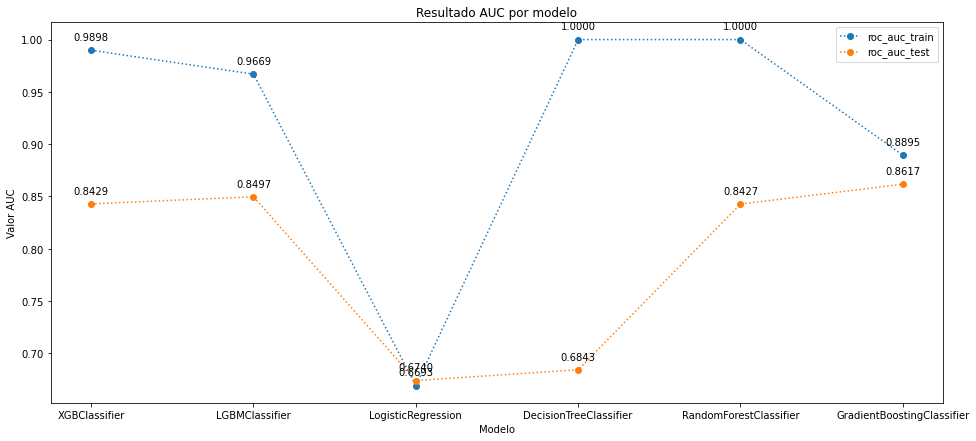

In [26]:
def add_label(xs, ys):
    for x,y in zip(xs,ys):
        label = "{:.4f}".format(y)
        plt.annotate(label, # this is the text
                    (x,y), # these are the coordinates to position the label
                    textcoords="offset points", # how to position the text
                    xytext=(0,10), # distance from text to points (x,y)
                    ha='center') # horizontal alignment can be left, right or center

plt.figure(figsize=(16, 7))
plt.plot(df_roc_auc_comparative['modelo'], df_roc_auc_comparative['roc_auc_train'], label='roc_auc_train', marker='o', linestyle=':')
plt.plot(df_roc_auc_comparative['modelo'], df_roc_auc_comparative['roc_auc_test'], label='roc_auc_test', marker='o', linestyle=':')
add_label(df_roc_auc_comparative['modelo'].tolist(), df_roc_auc_comparative['roc_auc_train'].tolist())
add_label(df_roc_auc_comparative['modelo'].tolist(), df_roc_auc_comparative['roc_auc_test'].tolist())

plt.title('Resultado AUC por modelo')
plt.xlabel('Modelo')
plt.ylabel('Valor AUC')
plt.legend()
plt.show()

En todos los modelos nos encontramos con un gran overfitting, es decir el modelo se esta aprendiendo los datos de entrenamiento y cuando recibe unos nuevos datos no es capaz de realizar una predicción correcta, sin embargo el modelo GradientBoostingClassifier es el que mejores resultados ha obtenido en esta primera prueba. Vamos a realizar un estudio de hiperparametros sobre los algoritmos GradientBoostingClassifier y XGBoost para realizar un tuneado de hiperparametros y asi intentar mejorar los resultados obtenidos.

## Estudio hiperparametros

In [27]:
def optimizacion(value_dict, model, size=(8, 4), X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    
    def __comparative_result(var_name, value_xaxis, values_train, values_test, title, size):
        plt.figure(figsize=size)
        plt.plot(value_xaxis, values_train, label='roc_auc_train', marker='o', linestyle=':')
        plt.plot(value_xaxis, values_test, label='roc_auc_test', marker='o', linestyle=':')
        plt.title(title)
        plt.xlabel(f'Valores en {var_name}')
        plt.ylabel('Valor AUC')
        plt.legend()
        plt.show()

    for param, values in value_dict.items():
        
        values_train, values_test = [], []
        for value in values:

            value_dict_ = {param:value}
            try:
                model_ = model(**value_dict_, verbosity=0)
            except:
                model_ = model(**value_dict_)
            model_.fit(X_train, y_train)
            values_train.append(roc_auc_score(y_train, model_.predict_proba(X_train)[::, 1]))
            values_test.append(roc_auc_score(y_test, model_.predict_proba(X_test)[::, 1]))

        __comparative_result(param, values, values_train, values_test, f'Optimizacion {param}', size)
        
        
def run_model(model, parameters, tunning, cv, scoring, size=(16, 8), X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    
    def __get_feature_importance(model, X_train, size):
    
        df_feat = pd.DataFrame(dict(zip(X_train.columns, model.best_estimator_.feature_importances_)), index=[0]).T.reset_index()
        df_feat.columns = ['colnames', 'feature_importances']
        df_feat = df_feat.sort_values('feature_importances', ascending=False).reset_index(drop=True)

        def __add_label(xs, ys):
            for x,y in zip(xs,ys):
                label = "{:.4f}".format(y)
                plt.annotate(label, # this is the text
                             (x,y), # these are the coordinates to position the label
                             textcoords="offset points", # how to position the text
                             xytext=(0,10), # distance from text to points (x,y)
                             ha='center') # horizontal alignment can be left, right or center

        plt.figure(figsize=size)
        plt.bar(df_feat['colnames'], df_feat['feature_importances'])
        plt.xticks(rotation=30)
        plt.title('Variables mas importances para el modelo')
        plt.xlabel('Colnames')
        plt.ylabel('Feature importances')
        __add_label(df_feat.colnames.tolist(), df_feat.feature_importances.tolist())
        plt.show()
        
    if tunning == 'GridSearchCV':
        model = GridSearchCV(model(), parameters, cv=cv, scoring=scoring).fit(X_train, y_train)
    elif tunning == 'RandomizedSearchCV':
        model = RandomizedSearchCV(model(), parameters, n_iter=100, cv=cv, scoring=scoring, random_state=22).fit(X_train, y_train)

    print(f'AUC en train: {roc_auc_score(y_train, model.predict_proba(X_train)[::, 1])}')
    print(f'AUC en test: {roc_auc_score(y_test, model.predict_proba(X_test)[::, 1])}')
    print(model.best_estimator_)
    __get_feature_importance(model, X_train, size)
    
    return model

Mediante la funcion optimizacion podremos ver como se comporta el modelo cuando se cambia el valor de uno de sus hiperparametros, de esta manera podremos realizar un tuneado de hiperparametros con GridSearchCV mas especificio.

#### XGBoost

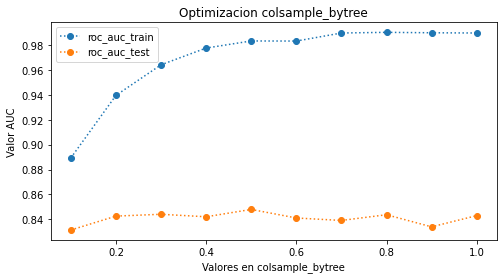

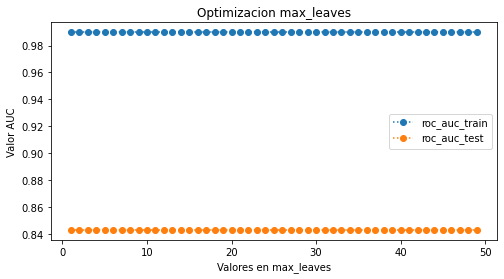

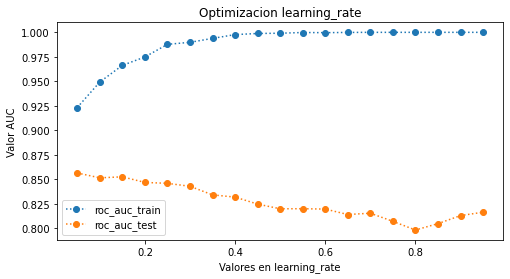

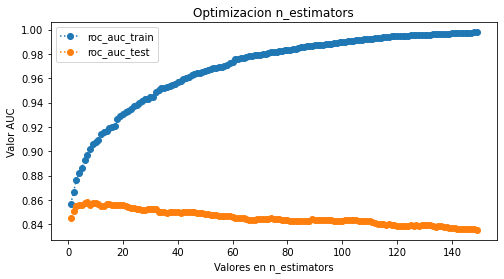

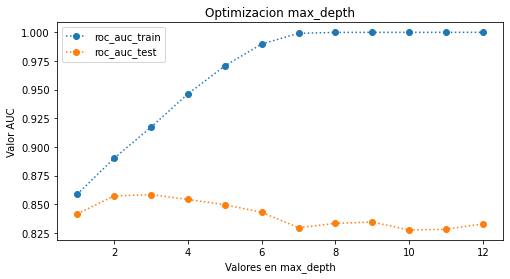

In [28]:
value_dict = {'colsample_bytree':np.linspace(0.1, 1.0, 10, endpoint=True).tolist(), 
              'max_leaves':np.arange(1, 50).tolist(), 
              'learning_rate':np.arange(0.05, 1, 0.05).tolist(), 
              'n_estimators':np.arange(1, 150).tolist(),
              'max_depth':np.arange(1, 13)}

optimizacion(value_dict, xgb.XGBClassifier)

AUC en train: 0.8869368567119156
AUC en test: 0.8603879826856766
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.5, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.2, max_delta_step=0, max_depth=3, max_leaves=6,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=50, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


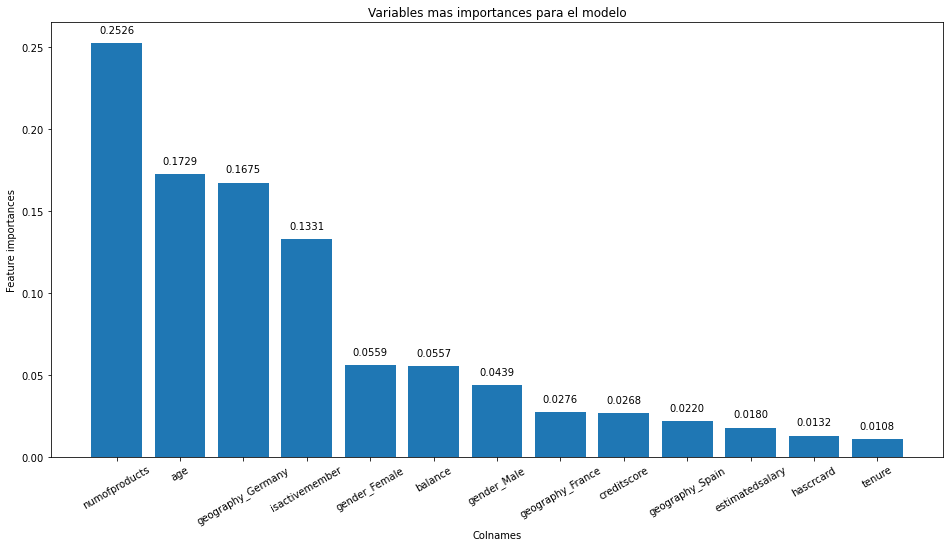

In [29]:
parametrosXGBoost = {'learning_rate': [0.1, 0.15, 0.2],
                     'max_depth': [2, 3, 5],
                     'n_estimators': [50, 75, 100],
                     'colsample_bytree': [0.5, 0.8],
                     'max_leaves': [6, 12, 15],
                     'objective':['binary:logistic']}

model_xgb_gridsearch = run_model(xgb.XGBClassifier, parametrosXGBoost, 'GridSearchCV', 5, 'roc_auc')

AUC en train: 0.8914212971342383
AUC en test: 0.8619057372037857
XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=0.8, gamma=0, gpu_id=-1,
              importance_type='gain', interaction_constraints='',
              learning_rate=0.05, max_delta_step=0, max_depth=4, max_leaves=29,
              min_child_weight=1, missing=nan, monotone_constraints='()',
              n_estimators=141, n_jobs=8, num_parallel_tree=1, random_state=0,
              reg_alpha=0, reg_lambda=1, scale_pos_weight=1, subsample=1,
              tree_method='exact', validate_parameters=1, verbosity=None)


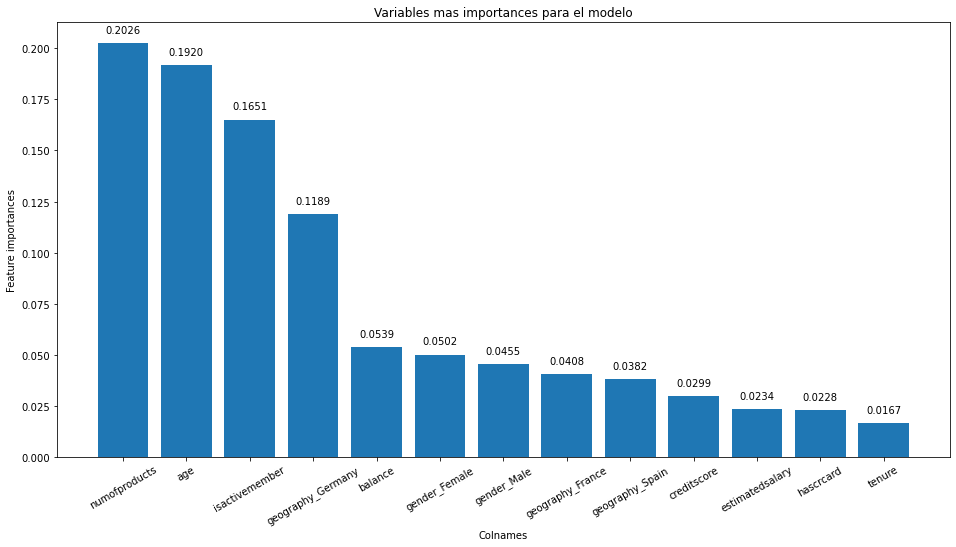

In [30]:
parametrosXGBoost_randSearch = {'colsample_bytree':np.linspace(0.1, 1.0, 10, endpoint=True), 
                                'max_leaves':np.arange(1, 50), 
                                'learning_rate':np.arange(0.05, 1, 0.05), 
                                'n_estimators':np.arange(1, 150),
                                'max_depth':np.arange(1, 13)}

model_xgb_randsearch = run_model(xgb.XGBClassifier, parametrosXGBoost_randSearch, 'RandomizedSearchCV', 5, 'roc_auc')

#### GradientBoostingClassifier

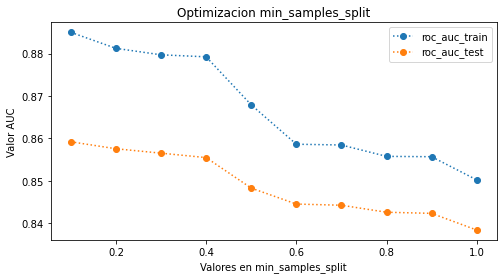

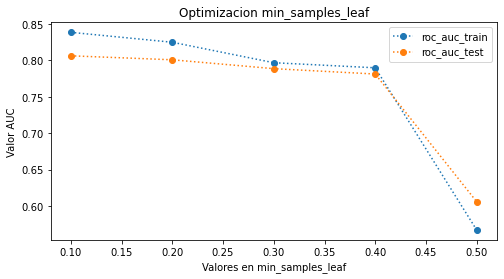

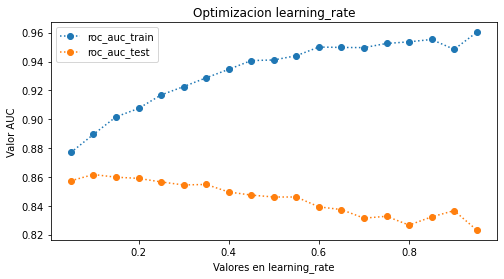

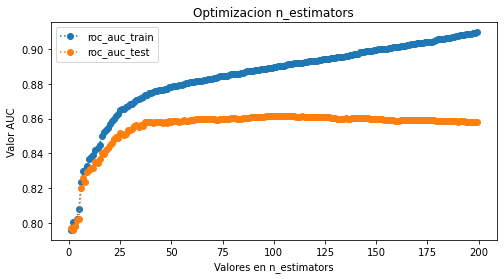

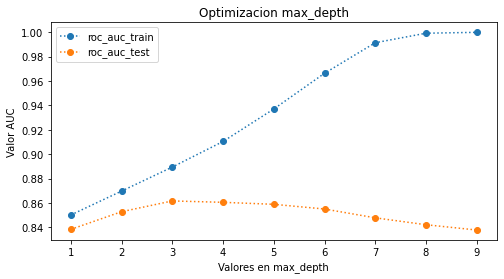

In [31]:
value_dict = {'min_samples_split':np.linspace(0.1, 1.0, 10, endpoint=True).tolist(), 
              'min_samples_leaf':np.linspace(0.1, 0.5, 5, endpoint=True).tolist(), 
              'learning_rate':np.arange(0.05, 1, 0.05).tolist(), 
              'n_estimators':np.arange(1, 200).tolist(),
              'max_depth':np.arange(1, 10)}

optimizacion(value_dict, GradientBoostingClassifier)

AUC en train: 0.8832471553544494
AUC en test: 0.8573517094226113
GradientBoostingClassifier(min_samples_split=12, n_estimators=75)


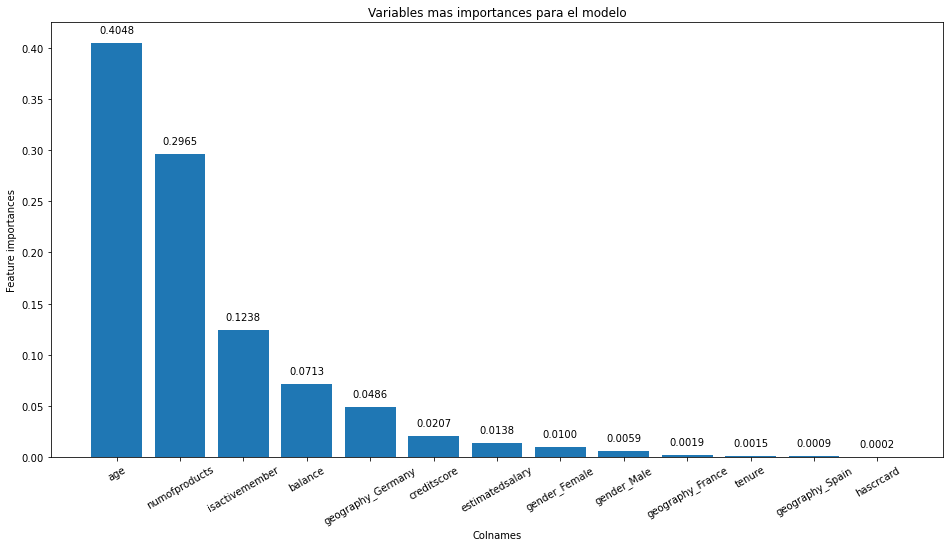

In [32]:
parametrosGradientBoosting = {'learning_rate': [0.1, 0.15, 0.2],
                              'max_depth': [2, 3, 5],
                              'validation_fraction': [0.1],
                              'n_estimators': [50, 75, 100],
                              'min_samples_leaf': [1, 5, 10],
                              'min_samples_split': [2, 6, 12]}

model_gradboosting_gridsearch = run_model(GradientBoostingClassifier, parametrosGradientBoosting, 'GridSearchCV', 5, 'roc_auc')

AUC en train: 0.8959697858220211
AUC en test: 0.861191949328703
GradientBoostingClassifier(learning_rate=0.2, max_depth=4,
                           min_samples_split=0.1, n_estimators=47)


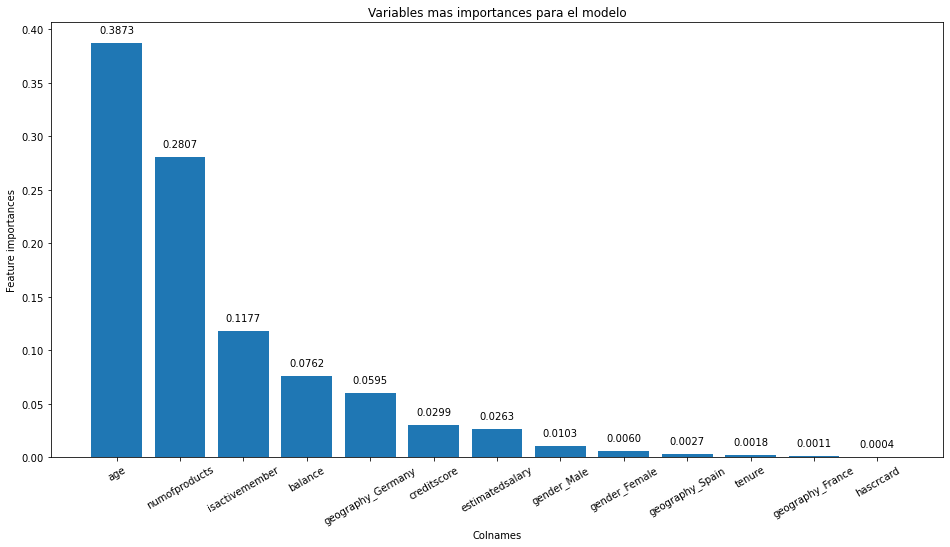

In [33]:
parametrosGradientBoosting_randSearch = {'max_depth':np.arange(1, 10), 
                                         'learning_rate':np.arange(0, 1, 0.05),
                                         'n_estimators': randint(4,200),
                                         'min_samples_split':np.linspace(0.1, 1.0, 10, endpoint=True)}

model_gradboosting_randsearch = run_model(GradientBoostingClassifier, parametrosGradientBoosting_randSearch, 'RandomizedSearchCV', 5, 'roc_auc')

### Comparativa metricas

In [34]:
def get_metrics(model_name, model, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):
    
    def __metrics(model, df_x, df_y):
        
        roc_auc = roc_auc_score(df_y, model.predict_proba(df_x)[::, 1])
        accuracy = accuracy_score(df_y, model.predict(df_x))
        precision = precision_score(df_y, model.predict(df_x))
        f1_score_ = f1_score(df_y, model.predict(df_x))
        recall = recall_score(df_y, model.predict(df_x))
        
        return roc_auc, accuracy, precision, f1_score_, recall
    
    df_metrics_train = pd.DataFrame(index=['auc', 'accuracy', 'precision', 'f1_score', 'recall'])
    df_metrics_train[model_name] = list(__metrics(model, X_train, y_train))

    df_metrics_test = pd.DataFrame(index=['auc', 'accuracy', 'precision', 'f1_score', 'recall'])
    df_metrics_test[model_name] = list(__metrics(model, X_test, y_test))
        
    return df_metrics_train, df_metrics_test


def get_plot_comparative_metrics(dict_models):

    i=0
    for model_name, model in dict_models.items():
        if i == 0:
            df_metrics_train, df_metrics_test = get_metrics(model_name, model)
        else:
            df_1, df_2 = get_metrics(model_name, model)
            df_metrics_train = pd.merge(df_metrics_train, df_1, left_index=True, right_index=True, how='inner')
            df_metrics_test = pd.merge(df_metrics_test, df_2, left_index=True, right_index=True, how='inner')           
        i=i+1

    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(32,8))
    for col in list(dict_models.keys()):
        ax1.plot(df_metrics_train.index, df_metrics_train[col], label=col, marker='o', linestyle=':')
        ax2.plot(df_metrics_test.index, df_metrics_test[col], label=col, marker='o', linestyle=':')
    ax1.set_title('Metricas en train')
    ax1.set_ylabel('Valores')
    ax1.legend()
    ax2.set_title('Metricas en test')
    ax2.set_ylabel('Valores')
    ax2.legend()
    plt.subplots_adjust(wspace=0.1, hspace=0)
    plt.show()
    
    print('#### Metricas en train')
    display(df_metrics_train)
    print('#### Metricas en test')
    display(df_metrics_test)
    
    
def plot_roc_lift(model, model_name, X_train=X_train, y_train=y_train, X_test=X_test, y_test=y_test):

    print(f'#### Curvas ROC y Lift para el modelo {model_name}')
    ns_probs = [0 for _ in range(len(X_test))]
    lr_probs = model.predict_proba(X_test)[::, 1]
    lr_probs_tr = model.predict_proba(X_train)[::, 1]

    ns_fpr, ns_tpr, _ = roc_curve(y_test, ns_probs)
    lr_fpr, lr_tpr, _ = roc_curve(y_test, lr_probs)
    lr_fpr_tr, lr_tpr_tr, _ = roc_curve(y_train, lr_probs_tr)

    auc_train = round(roc_auc_score(y_train, model.predict_proba(X_train)[::, 1]), 6)
    auc_test = round(roc_auc_score(y_test, model.predict_proba(X_test)[::, 1]), 6)

    fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, figsize=(30,14))
    ax1.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax1.plot(lr_fpr_tr, lr_tpr_tr, marker='.', label='Logistic')
    ax1.text(0.9, 0.05, f'auc={auc_train}', bbox=dict(facecolor='red', alpha=0.5))
    ax2.plot(ns_fpr, ns_tpr, linestyle='--', label='No Skill')
    ax2.plot(lr_fpr, lr_tpr, marker='.', label='Logistic')
    ax2.text(0.9, 0.05, f'auc={auc_test}', bbox=dict(facecolor='red', alpha=0.5))
    skplt.metrics.plot_lift_curve(y_train, model.predict_proba(X_train), ax=ax3, title=f'Curva Lift en train modelo {model_name}')
    skplt.metrics.plot_lift_curve(y_test, model.predict_proba(X_test), ax=ax4, title=f'Curva Lift en test modelo {model_name}')

    ax1.set_title(f'Curva ROC en train modelo {model_name}')
    ax1.set_xlabel('False Positive Rate')
    ax1.set_ylabel('True Positive Rate')
    ax1.legend()
    ax2.set_title(f'Curva ROC en test modelo {model_name}')
    ax2.set_xlabel('False Positive Rate')
    ax2.set_ylabel('True Positive Rate')
    ax2.legend()

    plt.subplots_adjust(wspace=0.08, hspace=0.25)
    plt.show()

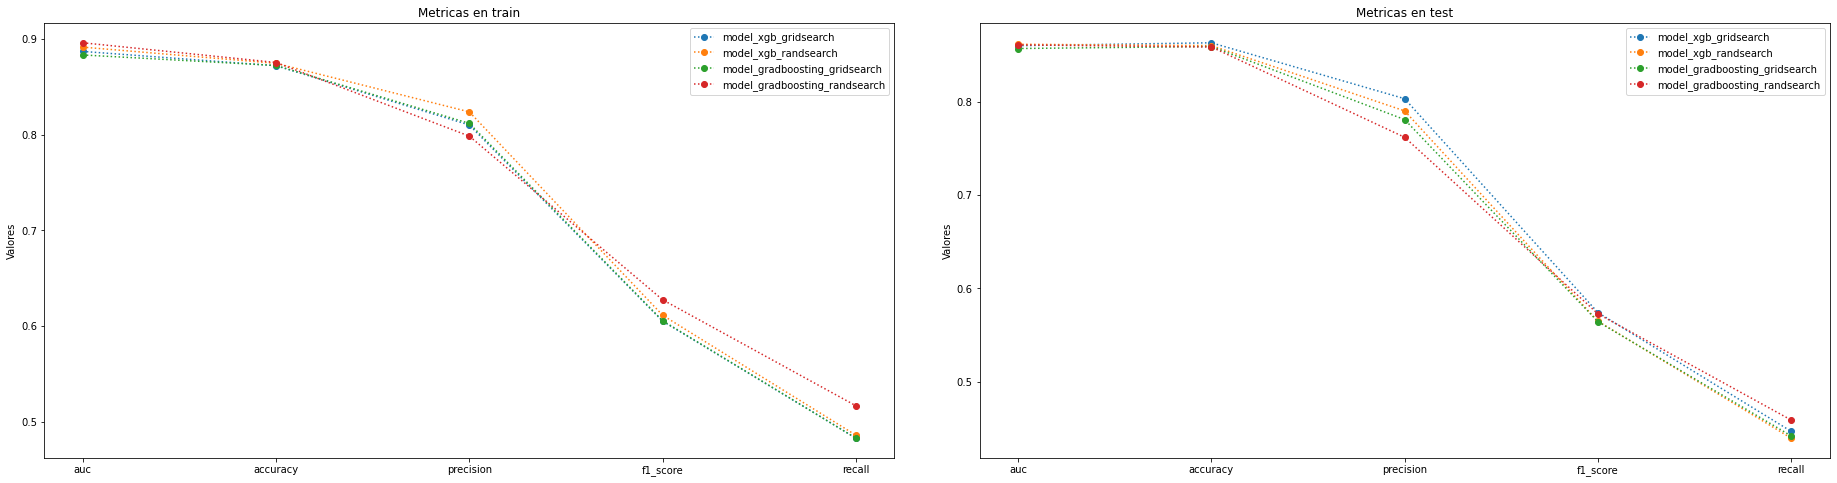

#### Metricas en train


,model_xgb_gridsearch,model_xgb_randsearch,model_gradboosting_gridsearch,model_gradboosting_randsearch
auc,0.886937,0.891421,0.883247,0.895970
accuracy,0.872000,0.874500,0.872250,0.875375
precision,0.810114,0.823775,0.811789,0.798479
f1_score,0.605243,0.611455,0.605710,0.627568
recall,0.483077,0.486154,0.483077,0.516923


#### Metricas en test


,model_xgb_gridsearch,model_xgb_randsearch,model_gradboosting_gridsearch,model_gradboosting_randsearch
auc,0.860388,0.861906,0.857352,0.861192
accuracy,0.863500,0.860500,0.859500,0.859000
precision,0.803493,0.790393,0.781116,0.762097
f1_score,0.574103,0.564743,0.564341,0.572727
recall,0.446602,0.439320,0.441748,0.458738


In [35]:
# Metricas por modelo
dict_models = {'model_xgb_gridsearch':model_xgb_gridsearch, 
               'model_xgb_randsearch':model_xgb_randsearch, 
               'model_gradboosting_gridsearch': model_gradboosting_gridsearch, 
               'model_gradboosting_randsearch':model_gradboosting_randsearch}

get_plot_comparative_metrics(dict_models)

#### Curvas ROC y Lift para el modelo XGBoost GridSearchCV


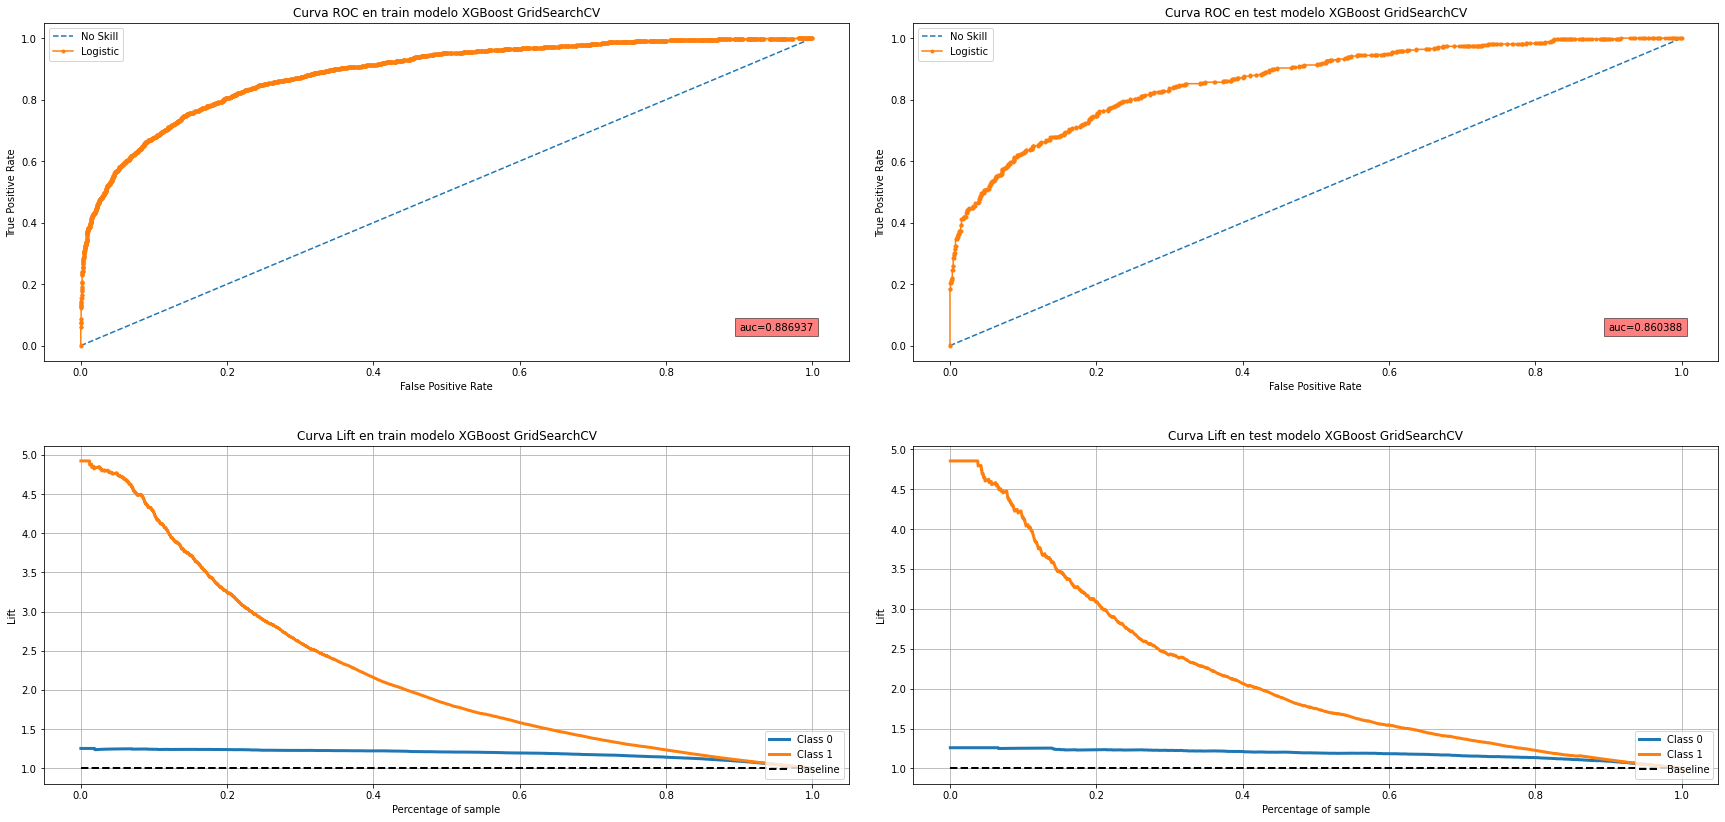

#### Curvas ROC y Lift para el modelo XGBoost RandomizedSearchCV


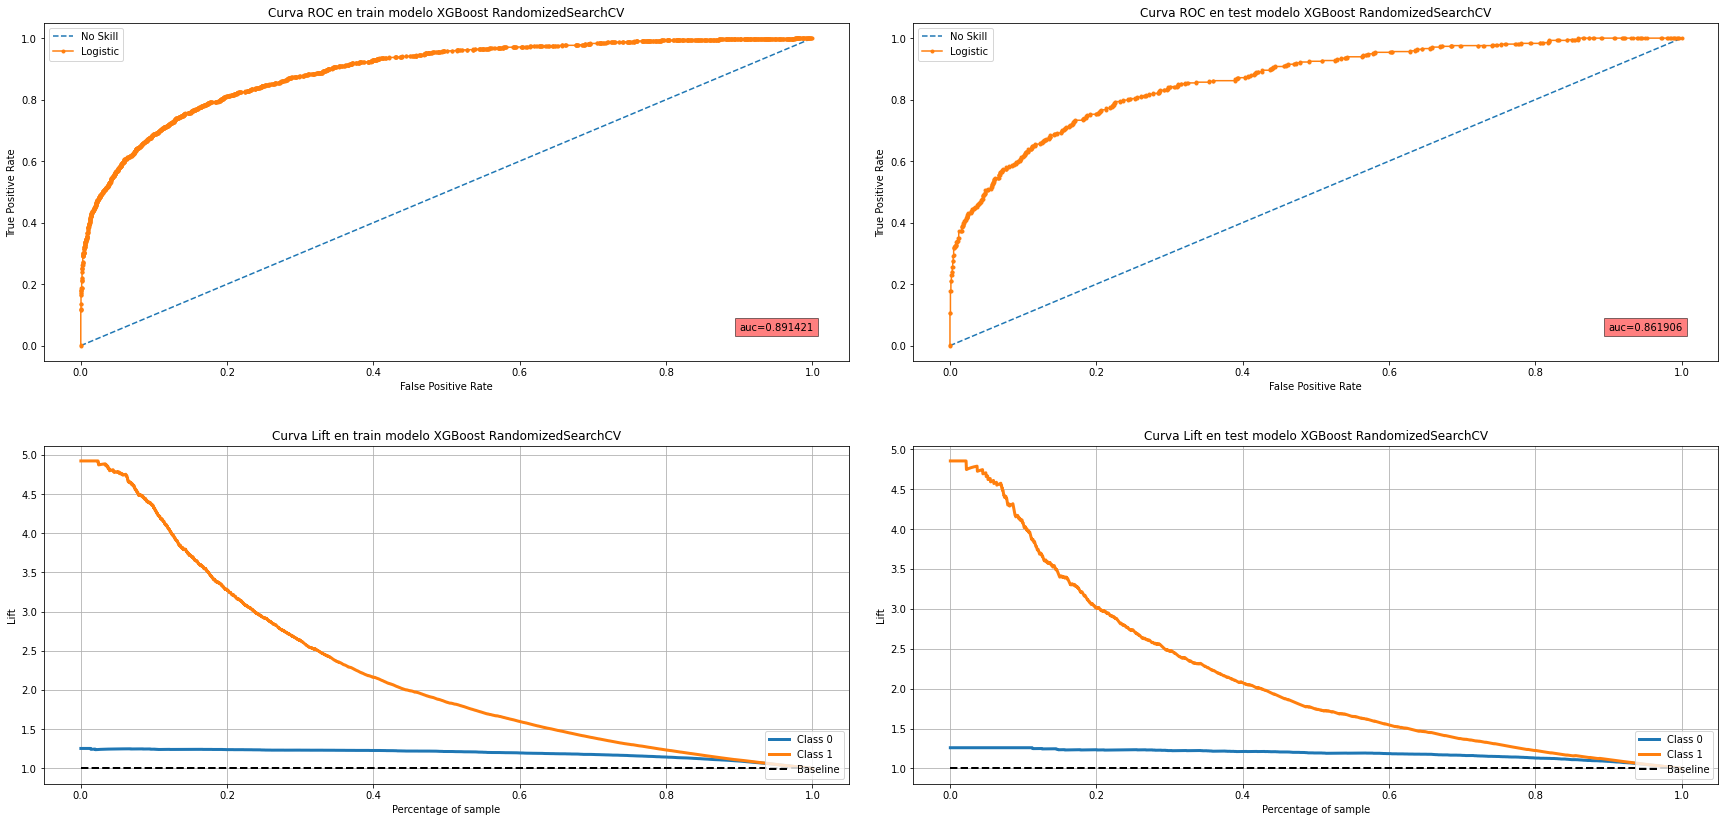

#### Curvas ROC y Lift para el modelo GradientBoostingClassifier GridSearchCV


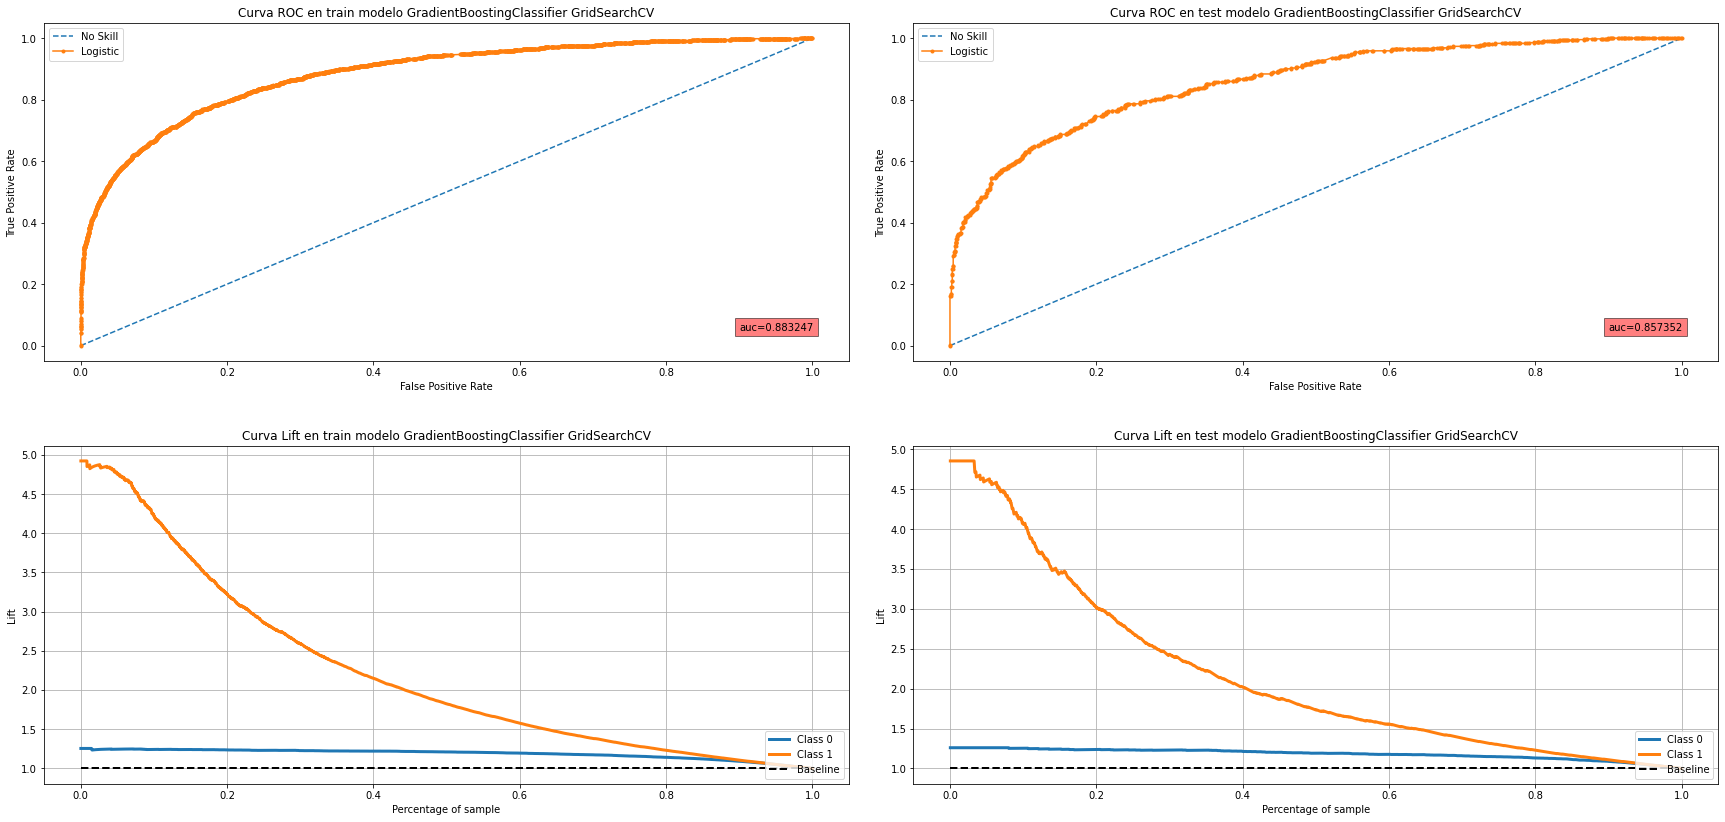

#### Curvas ROC y Lift para el modelo GradientBoostingClassifier RandomizedSearchCV


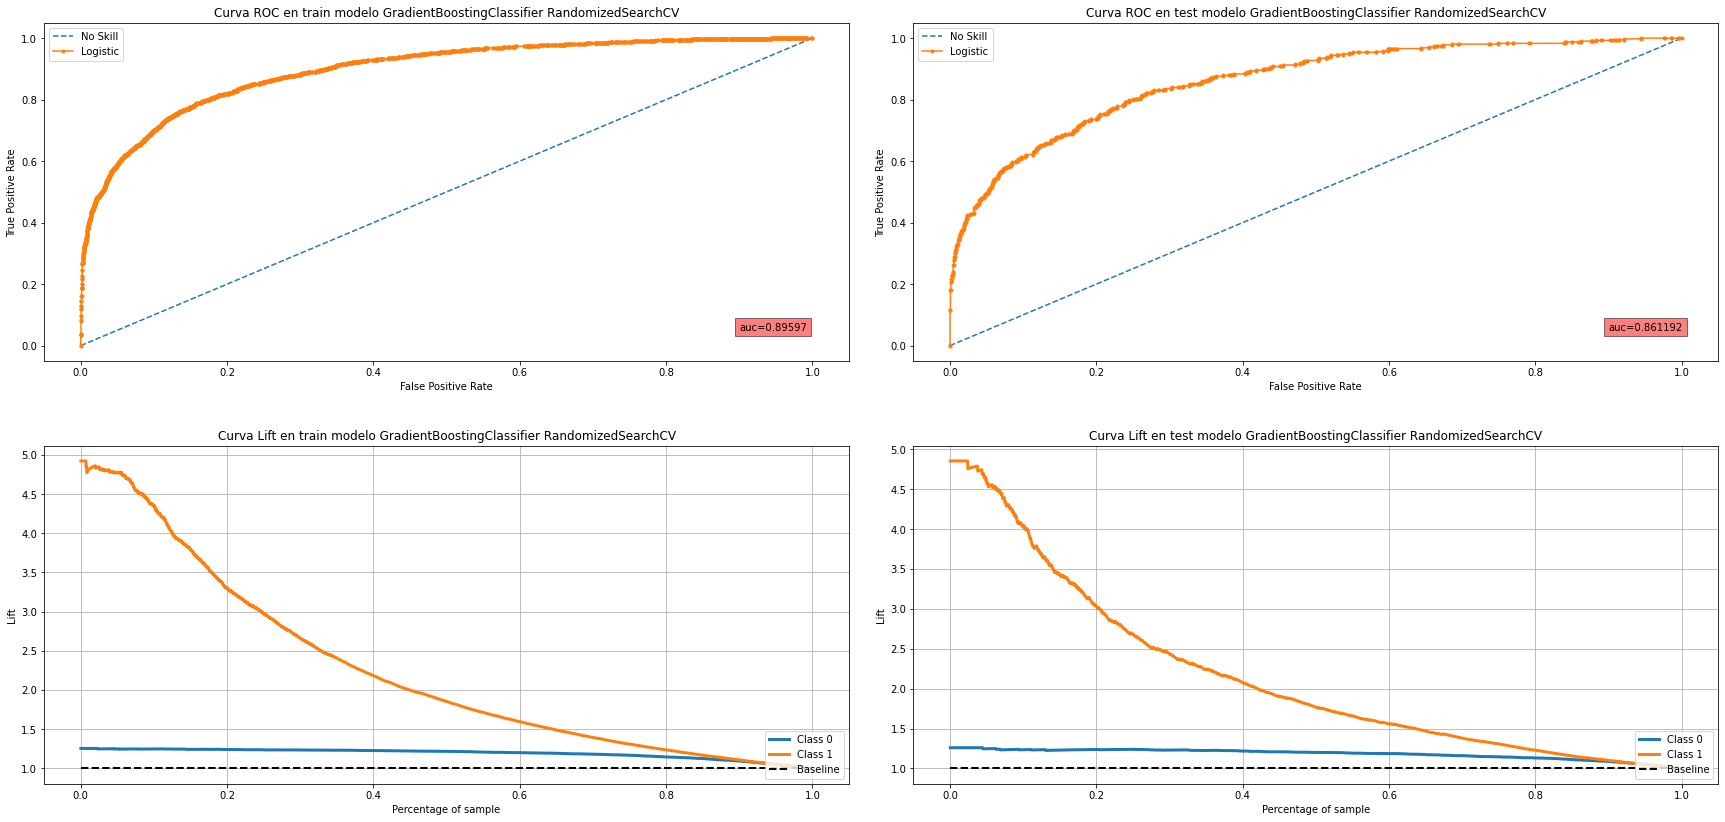

In [36]:
# Curvas ROC y Lift por modelo
plot_roc_lift(model_xgb_gridsearch, 'XGBoost GridSearchCV')
plot_roc_lift(model_xgb_randsearch, 'XGBoost RandomizedSearchCV')
plot_roc_lift(model_gradboosting_gridsearch, 'GradientBoostingClassifier GridSearchCV')
plot_roc_lift(model_gradboosting_randsearch, 'GradientBoostingClassifier RandomizedSearchCV')

Tras los diferentes resultados obtenidos, el algoritmo XGBoost desarrollado con GridSearchCV será el modelo utilizado para obtener la explicatividad.

&nbsp;
## Explicatividad
---

Generamos la explicatividad para el tablon de test, el dataset con la explicatividad es ordenado de mayor a menor score. 

In [52]:
def get_explain(mode, df, df_y, addPredict=True):

    explainer = shap.Explainer(model)
    intercept_value = explainer.expected_value[0]
    shap_values = explainer.shap_values(df)

    df_explain = pd.DataFrame(shap_values, columns=[f'{elem}_exp' for elem in df.columns], index=df.index)
    cols_exp = df_explain.columns
    df_explain['intercept_exp'] = intercept_value
    if addPredict == True:
        df_explain['predict'] = model.predict_proba(df)[::,1]

        df_explain_final = pd.concat([df, df_explain], axis=1)
        df_explain_final = pd.concat([df_explain_final, df_y], axis=1)
        df_explain_final = df_explain_final.sort_values('predict', ascending=False).reset_index(drop=True)
    else:
        df_explain_final = pd.concat([df, df_explain], axis=1)
    
    return df_explain_final, explainer, shap_values, cols_exp


def get_shap_plots(explainer, df_explain, j, X_output, cols_exp, size=(17, 8)):
    
    df_plt = df_explain.iloc[[j]][cols_exp].T.copy()
    df_plt.columns = ['Value']
    df_plt['positive'] = np.where(df_plt.Value > 0, True, False)
    df_plt.sort_values('Value', ascending=True, key=abs, inplace=True)
    df_plt.index = [elem[:-4] for elem in df_plt.index.tolist()]
    
    print(f'### Importancia de las variables para el registro {j}')
    display(df_explain.iloc[[j]][[elem[:-4] for elem in cols_exp]+['predict', 'exited']].reset_index(drop=True))

    fig = plt.figure(figsize=size)
    fig = df_plt['Value'].plot(kind='barh', color=df_plt.positive.map({True: 'r', False: 'b'}))
    plt.xlabel('Shap values')
    
    shap.force_plot(explainer.expected_value, np.array(df_explain.iloc[[j]][cols_exp]), df_explain.iloc[[j]][X_output.columns], matplotlib=True, show=True)
    

In [40]:
# Initialize your Jupyter notebook with initjs(), otherwise you will get an error message.
shap.initjs()

In [41]:
# Modelo del que vamos a sacar la explicatividad
model_shap = model_xgb_gridsearch.best_estimator_
X_output = X_test.copy()

In [42]:
df_explain, explainer, shap_values, cols_exp = get_explain(model_shap, X_output, y_test)
print(df_explain.shape)
df_explain.head(2)

(2000, 29)


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male,creditscore_exp,age_exp,tenure_exp,balance_exp,numofproducts_exp,hascrcard_exp,isactivemember_exp,estimatedsalary_exp,geography_France_exp,geography_Germany_exp,geography_Spain_exp,gender_Female_exp,gender_Male_exp,intercept_exp,predict,exited
0,466,56,2,111920.13,3,1,0,197634.11,0,1,0,1,0,0.111147,2.209279,0.026658,0.304409,2.714031,-0.004721,0.512655,-0.011681,0.007816,0.256868,0.002884,0.102142,0.094824,-1.873842,0.988484,1
1,625,55,8,118772.71,4,0,0,135853.62,0,1,0,1,0,0.033556,1.578788,-0.022329,0.322296,3.359180,0.010882,0.408005,0.081420,0.029509,0.256536,0.002257,0.122164,0.117866,-1.873842,0.988183,1


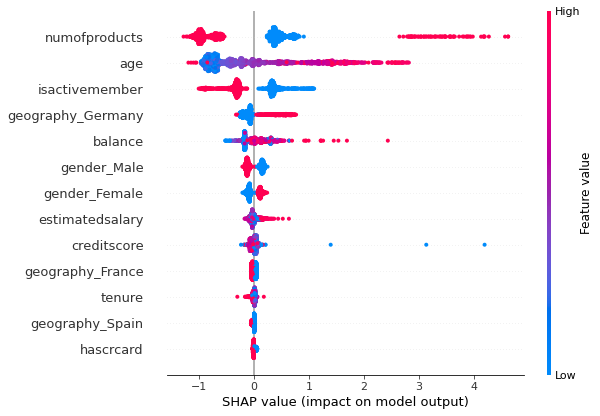

In [43]:
# Importancia de las variables 
shap.summary_plot(shap_values, X_output)

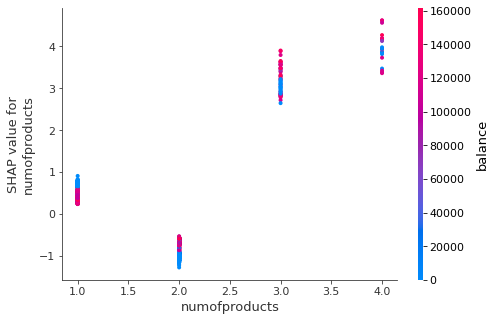

In [44]:
shap.dependence_plot('numofproducts', shap_values, X_output)

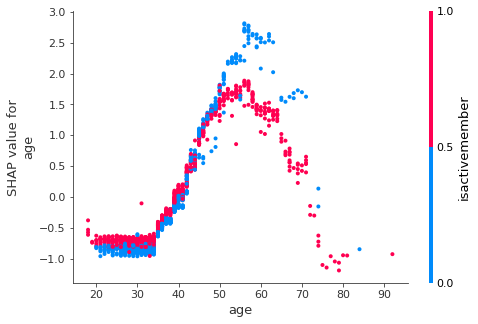

In [45]:
shap.dependence_plot('age', shap_values, X_output)

### Importancia de las variables para el registro 1


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male,predict,exited
0,625,55,8,118772.71,4,0,0,135853.62,0,1,0,1,0,0.988183,1


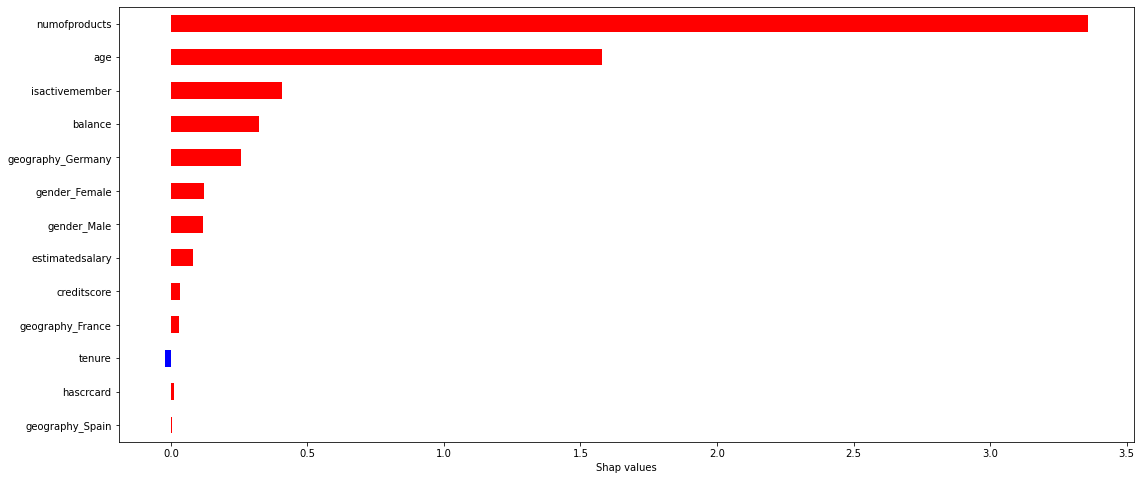

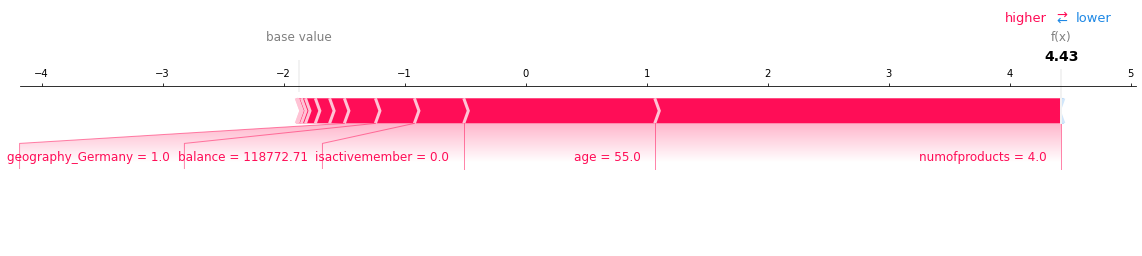

In [46]:
# Obtenemos la explicatividad del registro con mayor score
get_shap_plots(explainer, df_explain, 1, X_output, cols_exp, (18.2, 8))

### Importancia de las variables para el registro 200


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male,predict,exited
0,599,50,3,121159.65,1,0,0,4033.39,1,0,0,0,1,0.565863,1


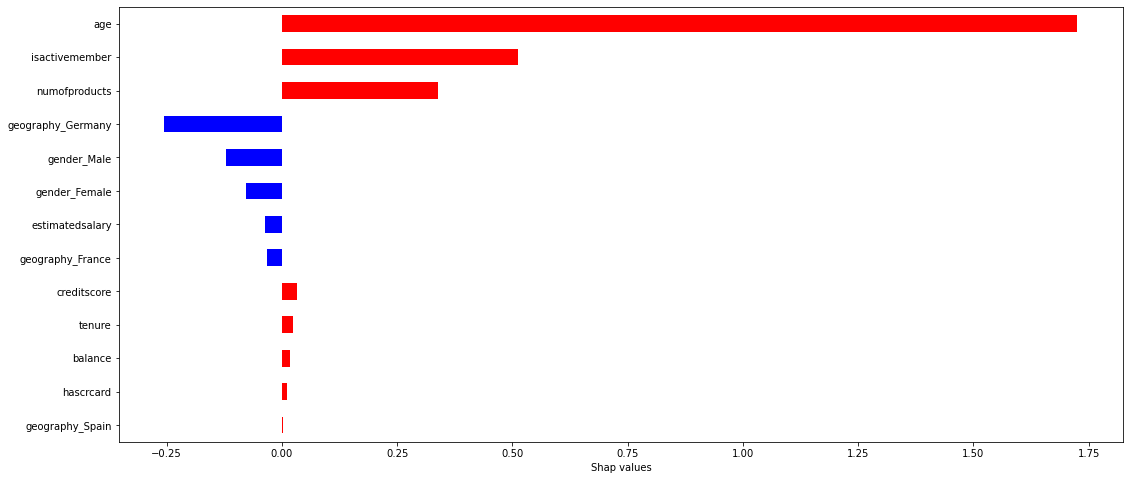

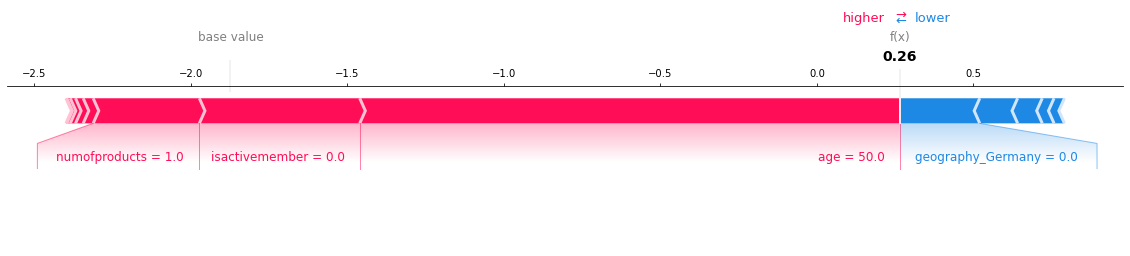

In [47]:
# Obtenemos la explicatividad de un registro intermedio
get_shap_plots(explainer, df_explain, 200, X_output, cols_exp, (18, 8))

### Importancia de las variables para el registro 1999


,creditscore,age,tenure,balance,numofproducts,hascrcard,isactivemember,estimatedsalary,geography_France,geography_Germany,geography_Spain,gender_Female,gender_Male,predict,exited
0,850,81,5,0.0,2,1,1,44827.47,1,0,0,0,1,0.009197,0


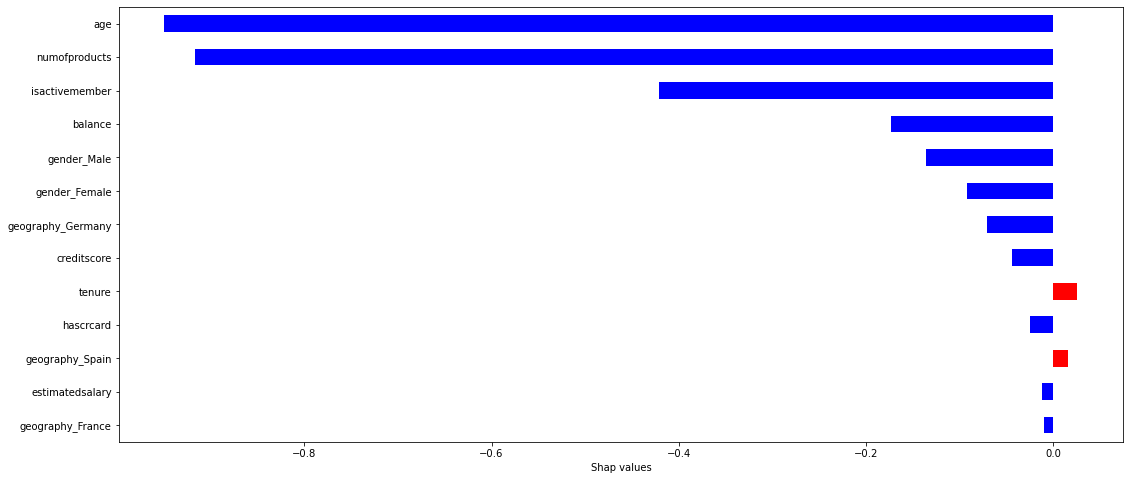

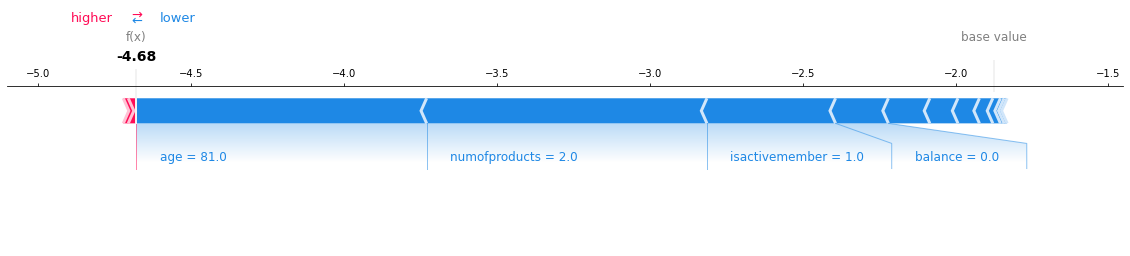

In [48]:
# Obtenemos la explicatividad del registro con menor score
get_shap_plots(explainer, df_explain, len(X_output)-1, X_output, cols_exp, (18, 8))

Se observa como aquellos registros con mayor score, son marcados con este score mayor debido al valor que tienen en las variables 'numofproducts' y 'age', ya que se tratan de una serie de clientes con una edad comprendida entre 40 y 55 años que no son clientes activos y que tienen una cantidad de productos alta. 